# Team EDA Baseline (Full Data + R2 Download)

This notebook is the teammate-ready baseline for EDA on the full V1 merged dataset (no additional cleaning/feature engineering in this notebook).

Scope:
- Validate `scripts/r2.env` configuration
- Optionally run `scripts/download_from_r2.sh` to fetch `datasets/<DATASET_VERSION>/`
- Load full parquet partitions as a DuckDB view (`spotify_full`). Pandas is not possible because Dataset is too big for a full EDA.
- Run starter SQL EDA queries (shape, null rates, top regions/charts, yearly streams, audio feature summary)

## 1) Executive Summary

After we are done here: 

## 2) Load Project Dependencies and Paths

In [48]:
from pathlib import Path
import os
import re
import json
import subprocess
from typing import Dict, List, Tuple
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name != "Project_Information":
    for candidate in [Path.cwd(), *Path.cwd().parents]:
        if (candidate / "scripts").exists() and (candidate / "datasets").exists():
            NOTEBOOK_DIR = candidate / "Project_Information" if (candidate / "Project_Information").exists() else candidate
            break

REPO_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "Project_Information" else NOTEBOOK_DIR
SCRIPTS_DIR = REPO_ROOT / "scripts"
DEFAULT_DATASET_VERSION = "v1"
DEFAULT_DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DEFAULT_DATASET_VERSION
R2_ENV_PATH = SCRIPTS_DIR / "r2.env"
R2_ENV_EXAMPLE_PATH = SCRIPTS_DIR / "r2.env.example"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs" / "team_eda_baseline"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Scripts dir: {SCRIPTS_DIR}")
print(f"Default download root: {DEFAULT_DOWNLOAD_ROOT}")
print(f"R2 env file: {R2_ENV_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Repo root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB
Scripts dir: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/scripts
Default download root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
R2 env file: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/scripts/r2.env
Output dir: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/Project_Information/outputs/team_eda_baseline


## 3) Parse and Validate `scripts/r2.env` Configuration

In [49]:
REQUIRED_R2_KEYS = [
    "R2_ENDPOINT",
    "R2_BUCKET",
    "AWS_ACCESS_KEY_ID",
    "AWS_SECRET_ACCESS_KEY",
    "DATASET_VERSION",
]


def _strip_balanced_quotes(value: str) -> str:
    if len(value) >= 2 and ((value[0] == '"' and value[-1] == '"') or (value[0] == "'" and value[-1] == "'")):
        return value[1:-1]
    return value


def parse_env_file(env_path: Path) -> Tuple[Dict[str, str], List[str]]:
    parsed: Dict[str, str] = {}
    errors: List[str] = []

    if not env_path.exists():
        errors.append(f"Missing env file: {env_path}")
        return parsed, errors

    for line_no, raw_line in enumerate(env_path.read_text(encoding="utf-8").splitlines(), start=1):
        line = raw_line.strip()
        if not line or line.startswith("#"):
            continue
        if "=" not in line:
            errors.append(f"Line {line_no}: missing '=' separator")
            continue

        key, value = line.split("=", 1)
        key = key.strip()
        value = value.strip()

        if not re.fullmatch(r"[A-Za-z_][A-Za-z0-9_]*", key):
            errors.append(f"Line {line_no}: invalid key '{key}'")
            continue

        dbl_quote_count = value.count('"')
        sgl_quote_count = value.count("'")
        if dbl_quote_count % 2 != 0 or sgl_quote_count % 2 != 0:
            errors.append(
                f"Line {line_no}: malformed quotes for key '{key}' -> {value!r}"
            )
            continue

        normalized = _strip_balanced_quotes(value).strip()

        if normalized.endswith('"') or normalized.endswith("'"):
            errors.append(
                f"Line {line_no}: value for '{key}' appears to have a trailing quote -> {value!r}"
            )

        parsed[key] = normalized

    missing = [k for k in REQUIRED_R2_KEYS if not parsed.get(k)]
    if missing:
        errors.append(f"Missing required keys: {missing}")

    return parsed, errors


r2_config, r2_config_errors = parse_env_file(R2_ENV_PATH)

if r2_config_errors:
    print("❌ r2.env validation failed:")
    for err in r2_config_errors:
        print(f"  - {err}")
    if R2_ENV_EXAMPLE_PATH.exists():
        print(f"\nTemplate available at: {R2_ENV_EXAMPLE_PATH}")
else:
    print("✅ r2.env validation passed")
    display(pd.DataFrame([r2_config]).T.rename(columns={0: "value"}))

✅ r2.env validation passed


,value
R2_ENDPOINT,https://a96b93c5d97cddb48fc674255fb687c7.r2.cl...
R2_BUCKET,ml-group-ab-datasets
AWS_ACCESS_KEY_ID,b4f318900453ff77a06d530e454aa330
AWS_SECRET_ACCESS_KEY,e196e275699090f32d71db4854983855b8b3fc05905a80...
DATASET_VERSION,v1


## 4) Implement Safe Environment Variable Export for Shell Commands

In [50]:
def build_sanitized_env(base_env: Dict[str, str], overrides: Dict[str, str] | None = None) -> Dict[str, str]:
    if r2_config_errors:
        raise ValueError("Cannot build environment: r2.env is invalid.")

    env = dict(os.environ)
    for key in REQUIRED_R2_KEYS:
        env[key] = str(base_env[key]).strip()

    if overrides:
        for k, v in overrides.items():
            if v is not None:
                env[k] = str(v)

    return env


def run_bash_script(script_path: Path, env: Dict[str, str], cwd: Path, timeout: int = 3600) -> subprocess.CompletedProcess:
    if not script_path.exists():
        raise FileNotFoundError(f"Missing script: {script_path}")

    cmd = ["bash", str(script_path)]
    result = subprocess.run(
        cmd,
        cwd=str(cwd),
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
    )

    print("--- stdout ---")
    print(result.stdout[-4000:] if result.stdout else "<empty>")
    print("--- stderr ---")
    print(result.stderr[-4000:] if result.stderr else "<empty>")
    print(f"Exit code: {result.returncode}")

    if result.returncode != 0:
        raise RuntimeError(
            "Download script failed. Check stdout/stderr above. "
            "For permission-related preflight errors, try SKIP_R2_PREFLIGHT=1."
        )

    return result

print("✅ Shell helper ready")

✅ Shell helper ready


## 5) Run Dataset Download Script

This cell is safe by default (`RUN_DOWNLOAD = False`). Set it to `True` when ready.

In [51]:
DOWNLOAD_SCRIPT = SCRIPTS_DIR / "download_from_r2.sh"
DATASET_VERSION = r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION) if not r2_config_errors else DEFAULT_DATASET_VERSION
DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DATASET_VERSION

RUN_DOWNLOAD = False  # modify to False to skip actual download

print(f"Default DATASET_VERSION: {DATASET_VERSION}")
print(f"Default DOWNLOAD_ROOT: {DOWNLOAD_ROOT}")

if RUN_DOWNLOAD:
    env_default = build_sanitized_env(
        r2_config,
        overrides={
            "DATASET_VERSION": DATASET_VERSION,
            "DOWNLOAD_ROOT": str(DOWNLOAD_ROOT),
        },
    )
    run_bash_script(DOWNLOAD_SCRIPT, env=env_default, cwd=REPO_ROOT)
else:
    print("Skipped default run. Set RUN_DOWNLOAD=True to execute.")

Default DATASET_VERSION: v1
Default DOWNLOAD_ROOT: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
Skipped default run. Set RUN_DOWNLOAD=True to execute.


## 6) Load Parquet as DuckDB View (No Full In-Memory DataFrame)

In [52]:
if "DOWNLOAD_ROOT" not in globals():
    fallback_version = (
        r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION)
        if "r2_config" in globals() and "DEFAULT_DATASET_VERSION" in globals()
        else "v1"
    )
    DOWNLOAD_ROOT = REPO_ROOT / "datasets" / fallback_version

active_download_root = DOWNLOAD_ROOT
full_root = active_download_root / "full"
if not full_root.exists():
    raise FileNotFoundError(f"Full dataset folder not found: {full_root}")

parquet_files = sorted(full_root.rglob("*.parquet"))
if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under: {full_root}")

print(f"Active download root: {active_download_root}")
print(f"Total parquet files in full dataset: {len(parquet_files)}")

try:
    import duckdb
except ImportError as exc:
    raise ImportError(
        "duckdb is required for SQL-based EDA. Install it with: pip install duckdb"
    ) from exc

con = duckdb.connect(database=":memory:")
parquet_glob = (full_root / "year=*" / "*.parquet").as_posix()

con.execute(
    f"""
    CREATE OR REPLACE VIEW spotify_full AS
    SELECT *
    FROM read_parquet('{parquet_glob}', hive_partitioning = true);
    """
)

shape_df = con.execute("SELECT COUNT(*) AS row_count, COUNT(*) FILTER (WHERE true) AS sanity FROM spotify_full").df()
schema_df = con.execute("DESCRIBE spotify_full").df()

display(shape_df)
display(schema_df)

print("DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.")

Active download root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
Total parquet files in full dataset: 24


,row_count,sanity
0,26174269,26174269


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None


DuckDB view `spotify_full` is ready. Use SQL queries in the next cell for EDA.


## 7) Dataset Overview and Data Quality Assesssment

In [53]:
def run_sql(title: str, query: str):
    print(f"\n=== {title} ===")
    display(con.execute(query).df())

run_sql(
    "Rows per year",
    """
    SELECT year, COUNT(*) AS row_count
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Null rates for key EDA columns",
    """
    SELECT
      AVG(CASE WHEN streams IS NULL THEN 1.0 ELSE 0.0 END) AS streams_null_rate,
      AVG(CASE WHEN rank IS NULL THEN 1.0 ELSE 0.0 END) AS rank_null_rate,
      AVG(CASE WHEN region IS NULL THEN 1.0 ELSE 0.0 END) AS region_null_rate,
      AVG(CASE WHEN chart IS NULL THEN 1.0 ELSE 0.0 END) AS chart_null_rate
    FROM spotify_full;
    """,
)

run_sql(
    "Top regions",
    """
    SELECT region, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY region
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Top chart types",
    """
    SELECT chart, COUNT(*) AS cnt
    FROM spotify_full
    GROUP BY chart
    ORDER BY cnt DESC
    LIMIT 15;
    """,
)

run_sql(
    "Yearly streams summary",
    """
    SELECT
      year,
      COUNT(*) AS n_rows,
      AVG(TRY_CAST(streams AS DOUBLE)) AS streams_mean,
      MEDIAN(TRY_CAST(streams AS DOUBLE)) AS streams_median,
      SUM(TRY_CAST(streams AS DOUBLE)) AS streams_sum
    FROM spotify_full
    GROUP BY year
    ORDER BY year;
    """,
)

run_sql(
    "Audio feature summary",
    """
    SELECT
      AVG(TRY_CAST(af_danceability AS DOUBLE)) AS danceability_mean,
      AVG(TRY_CAST(af_energy AS DOUBLE)) AS energy_mean,
      AVG(TRY_CAST(af_valence AS DOUBLE)) AS valence_mean,
      AVG(TRY_CAST(af_tempo AS DOUBLE)) AS tempo_mean
    FROM spotify_full;
    """,
)

print("DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.")


=== Rows per year ===


,year,row_count
0,2017,4401837
1,2018,4863055
2,2019,5412686
3,2020,5793155
4,2021,5703536



=== Null rates for key EDA columns ===


,streams_null_rate,rank_null_rate,region_null_rate,chart_null_rate
0,0.22359,0.0,0.0,0.0



=== Top regions ===


,region,cnt
0,Argentina,455311
1,United States,455085
2,Austria,454596
3,Brazil,454441
4,Australia,453117
5,Canada,452296
6,Global,451804
7,United Kingdom,450732
8,Switzerland,449658
9,Malaysia,449354



=== Top chart types ===


,chart,cnt
0,top200,20321961
1,viral50,5852308



=== Yearly streams summary ===


,year,n_rows,streams_mean,streams_median,streams_sum
0,2017,4401837,51514.662948,9003.0,1.744577e+11
1,2018,4863055,54883.827774,9271.0,2.052286e+11
2,2019,5412686,55452.147561,9631.0,2.334656e+11
3,2020,5793155,55681.434756,9951.0,2.533957e+11
4,2021,5703536,57827.963363,9750.0,2.564694e+11



=== Audio feature summary ===


,danceability_mean,energy_mean,valence_mean,tempo_mean
0,0.685822,0.643769,0.523052,121.163427


DuckDB starter EDA queries completed. Teammates can now add custom SQL blocks.


## 7) EDA



In [54]:
con.execute("SELECT * FROM spotify_full LIMIT 10").df()


,title,rank,date,artist,url,region,chart,trend,streams,track_id,...,country_major_religions,country_govt_type,country_driving_side,cultural_distance_mean,cultural_distance_median,cultural_distance_min,cultural_distance_max,cultural_distance_count,cultural_top5_targets,index
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0,6mICuAdrwEjh6Y6lroV2Kg,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0,7DM4BPaS7uofFul3ywMe46,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0,3AEZUABDXNtecAOSC1qTfo,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0,58IL315gMSTD37DOZPJ2hf,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0,5J1c3M4EldCfNxXwrwt8mT,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0,1MpKZi1zTXpERKwxmOu1PH,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0,3QwBODjSEzelZyVjxPOHdq,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0,0sXvAOmXgjR2QUqLK1MltU,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0,20ZAJdsKB5IGbGj4ilRt2o,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0


In [55]:
# --- Quick sanity checks (DuckDB-based, no full in-memory load) ---


assert "con" in globals(), "DuckDB connection `con` not found. Run sections 4–6 first."
TABLE = "spotify_full"

# Shape (rows, columns)
row_count = con.execute(f"SELECT COUNT(*) AS row_count FROM {TABLE}").df().loc[0, "row_count"]
n_cols = con.execute(f"DESCRIBE {TABLE}").df().shape[0]
print(f"Shape: ({row_count:,} rows, {n_cols} columns)")

# Data types (DuckDB schema)
schema_df = con.execute(f"DESCRIBE {TABLE}").df()
display(schema_df)

# Missingness: compute null rates for all columns (top 15 by null rate)
null_rows = []
for col in schema_df["column_name"].tolist():
    # Quote identifiers safely for DuckDB
    col_quoted = f'"{col}"'
    q = f"""SELECT '{col}' AS column_name,
                    AVG(CASE WHEN {col_quoted} IS NULL THEN 1.0 ELSE 0.0 END) AS null_rate
             FROM {TABLE}"""
    null_rows.append(con.execute(q).df())

null_df = pd.concat(null_rows, ignore_index=True).sort_values("null_rate", ascending=False)
print("\nMissingness (top 15 by null rate):")
display(null_df.head(15))

# Summary stats for numeric-like columns (edit this list to match your modeling target/features)
candidate_numeric = ["streams", "rank", "year", "af_danceability", "af_energy", "af_valence", "af_tempo"]
existing = set(schema_df["column_name"].tolist())
numeric_like = [c for c in candidate_numeric if c in existing]
print("\nNumeric-like columns we will summarize:", numeric_like)

summary_blocks = []
for c in numeric_like:
    c_q = f"TRY_CAST({c} AS DOUBLE)"
    q = f"""SELECT
                '{c}' AS column,
                COUNT(*) AS n_total,
                SUM(CASE WHEN {c} IS NULL THEN 1 ELSE 0 END) AS n_null,
                COUNT({c_q}) AS n_numeric,
                MIN({c_q}) AS min,
                AVG({c_q}) AS mean,
                MEDIAN({c_q}) AS median,
                STDDEV_SAMP({c_q}) AS std,
                MAX({c_q}) AS max
              FROM {TABLE}"""
    summary_blocks.append(con.execute(q).df())

if summary_blocks:
    numeric_summary = pd.concat(summary_blocks, ignore_index=True)
    display(numeric_summary)
else:
    print("No numeric-like columns found from the candidate list. Update `candidate_numeric` above.")


Shape: (26,174,269 rows, 46 columns)


,column_name,column_type,null,key,default,extra
0,title,VARCHAR,YES,None,None,None
1,rank,VARCHAR,YES,None,None,None
2,date,VARCHAR,YES,None,None,None
3,artist,VARCHAR,YES,None,None,None
4,url,VARCHAR,YES,None,None,None
5,region,VARCHAR,YES,None,None,None
6,chart,VARCHAR,YES,None,None,None
7,trend,VARCHAR,YES,None,None,None
8,streams,VARCHAR,YES,None,None,None
9,track_id,VARCHAR,YES,None,None,None



Missingness (top 15 by null rate):


,column_name,null_rate
8,streams,0.223590
45,index,0.193528
44,cultural_top5_targets,0.193528
43,cultural_distance_count,0.193528
42,cultural_distance_max,0.193528
41,cultural_distance_min,0.193528
40,cultural_distance_median,0.193528
39,cultural_distance_mean,0.193528
33,country_population,0.034378
38,country_driving_side,0.034378



Numeric-like columns we will summarize: ['streams', 'rank', 'year', 'af_danceability', 'af_energy', 'af_valence', 'af_tempo']


,column,n_total,n_null,n_numeric,min,mean,median,std,max
0,streams,26174269,5852308.0,20321961,1001.0,55261.251042,9565.000,209586.974960,1.974970e+07
1,rank,26174269,0.0,26174269,1.0,80.921906,67.000,59.185820,2.000000e+02
2,year,26174269,0.0,26174269,2017.0,2019.134999,2019.000,1.390404,2.021000e+03
3,af_danceability,26174269,304251.0,25870018,0.0,0.685822,0.704,0.137278,9.880000e-01
4,af_energy,26174269,304251.0,25870018,0.0,0.643769,0.662,0.166601,1.000000e+00
5,af_valence,26174269,304251.0,25870018,0.0,0.523052,0.523,0.222981,9.990000e-01
6,af_tempo,26174269,304251.0,25870018,0.0,121.163427,118.611,29.399339,2.384310e+02


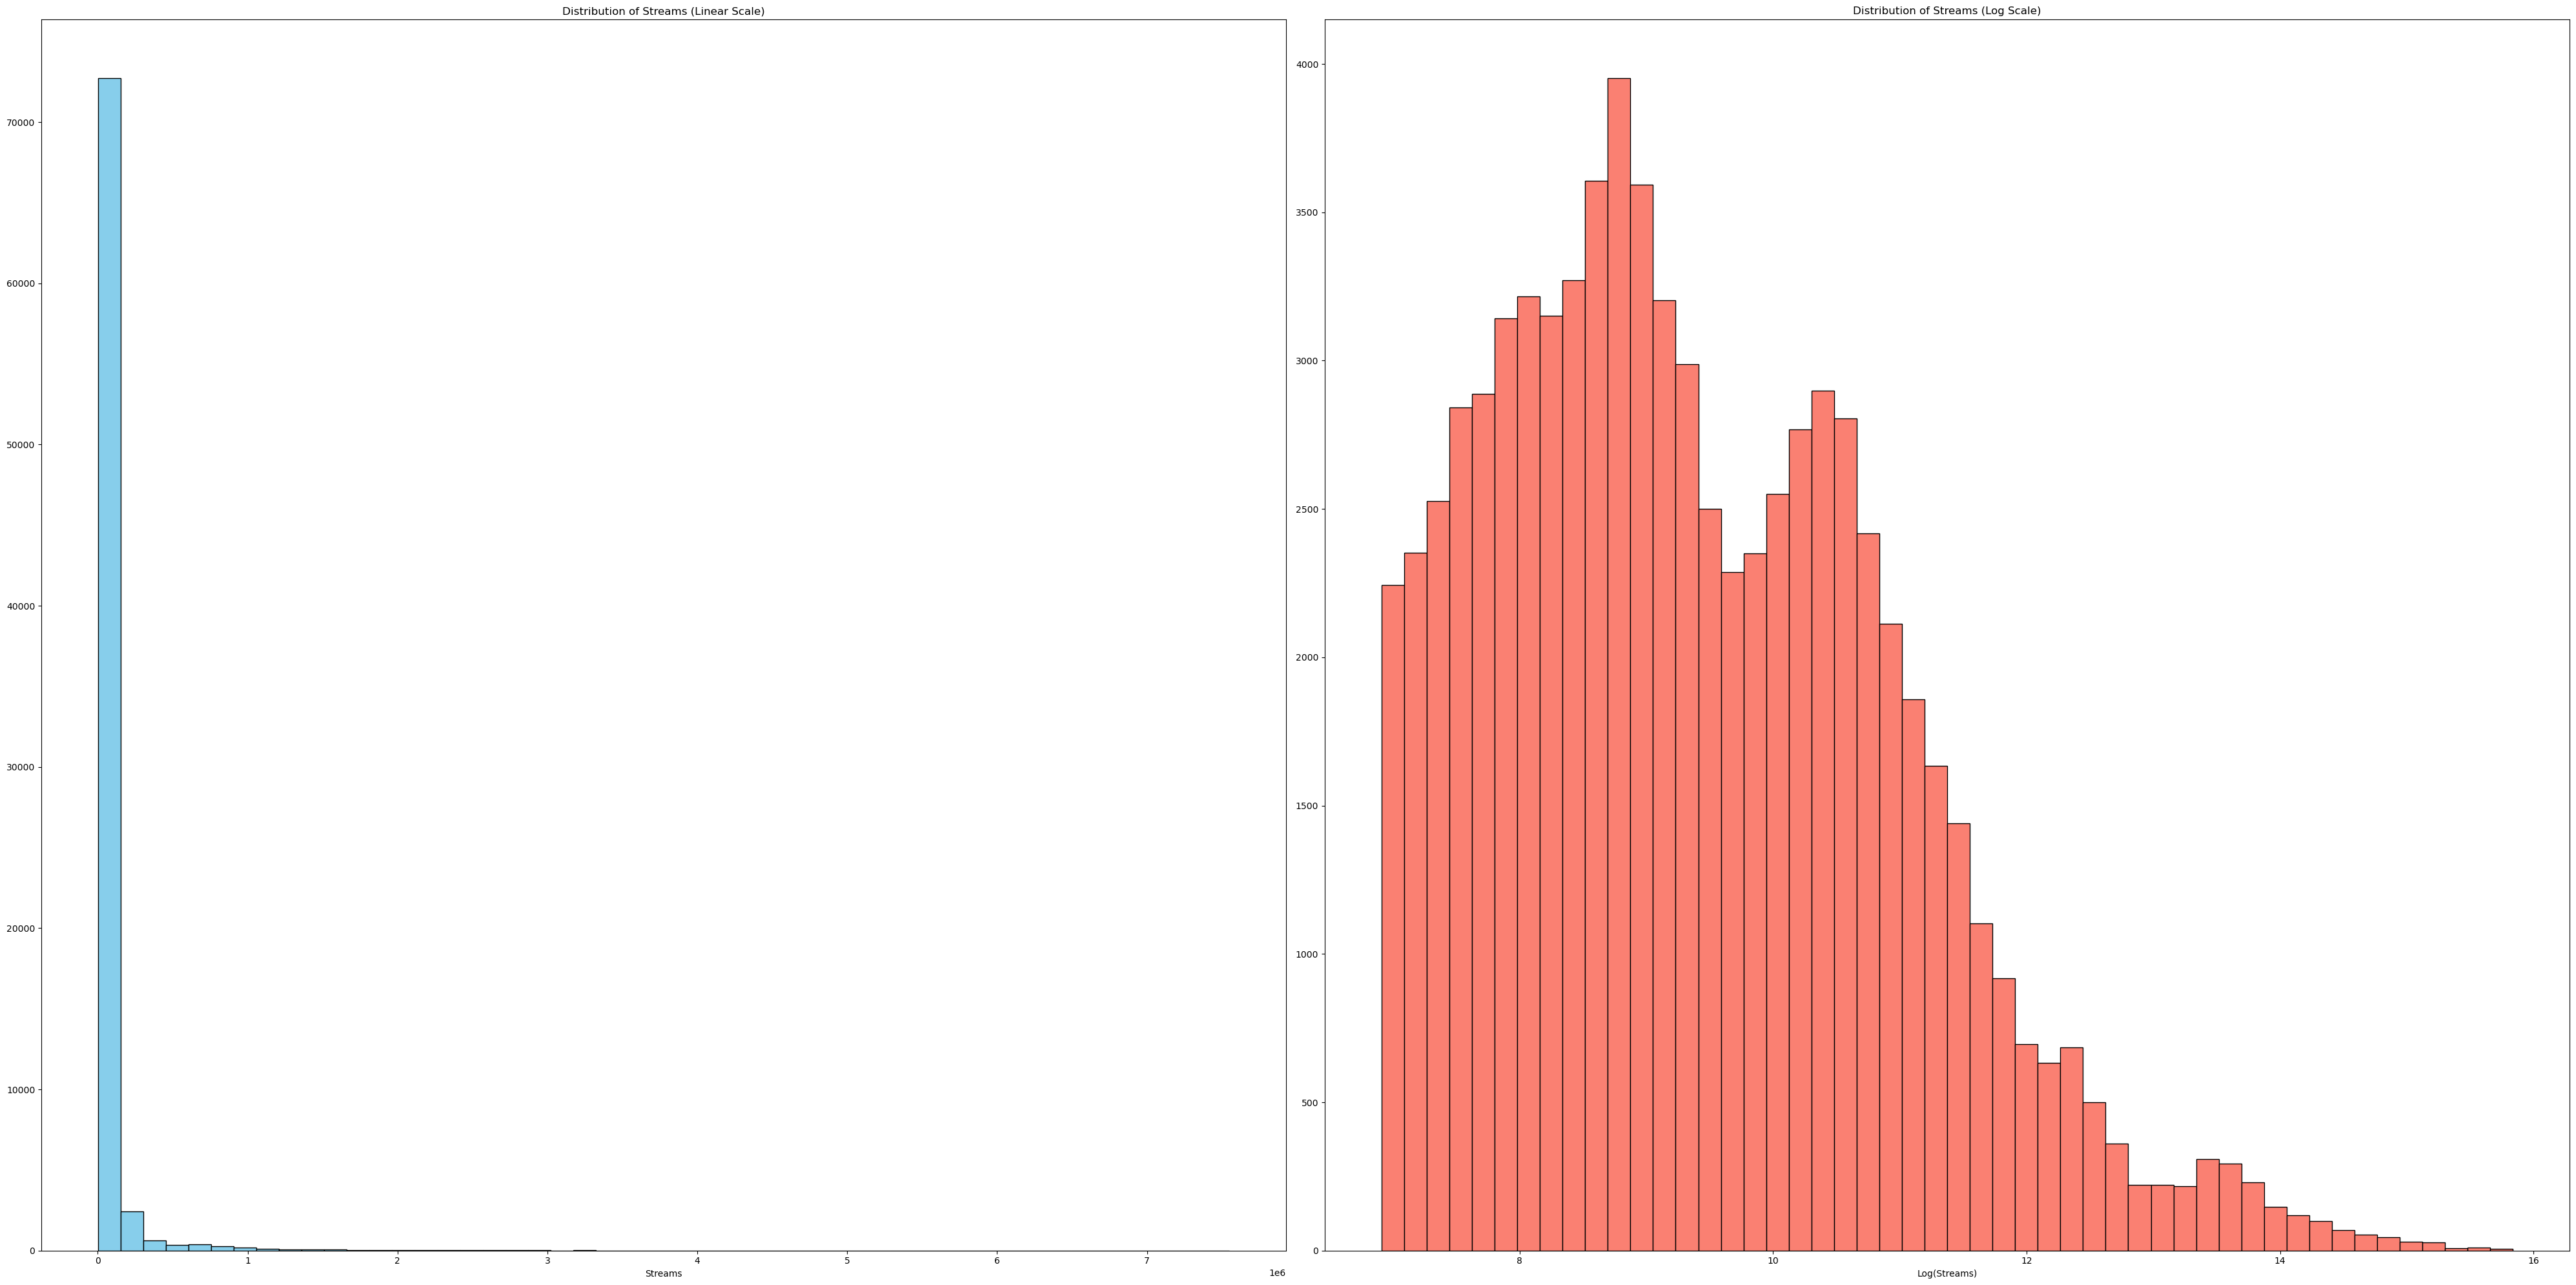

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Sample the data for visualization (as the dataset is too big for full pandas plotting)
sample_df = con.execute("SELECT TRY_CAST(streams AS DOUBLE) as streams FROM spotify_full WHERE streams IS NOT NULL USING SAMPLE 100000").df()

plt.figure(figsize=(40, 20))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution 
plt.subplot(1, 2, 2)
plt.hist(np.log1p(sample_df['streams']), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()

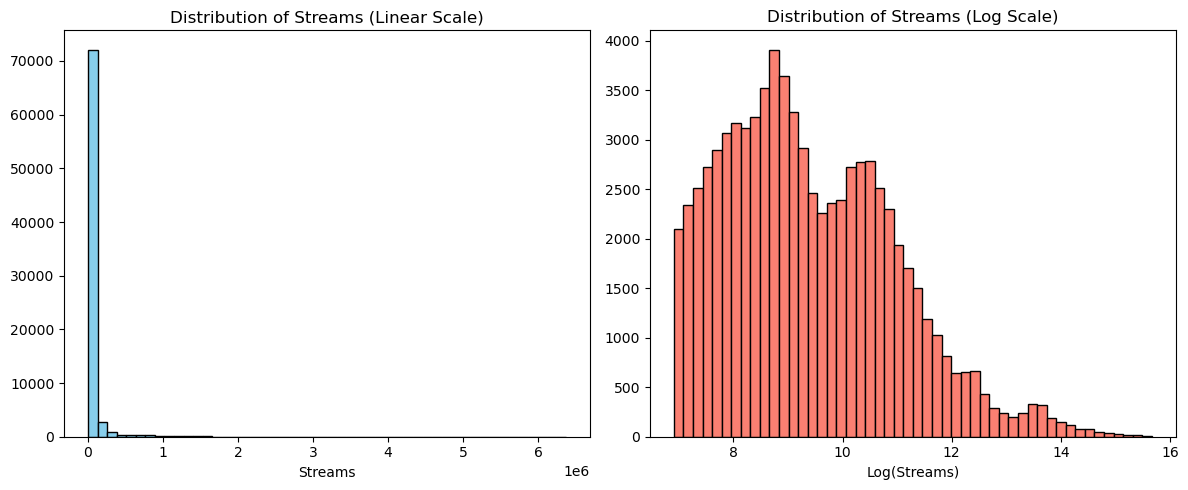

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Sample the data for visualization (as the dataset is too big for full pandas plotting)
sample_df = con.execute("SELECT TRY_CAST(streams AS DOUBLE) as streams FROM spotify_full WHERE streams IS NOT NULL USING SAMPLE 100000").df()

plt.figure(figsize=(12, 5))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution 
plt.subplot(1, 2, 2)
plt.hist(np.log1p(sample_df['streams']), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()

#### Due to Highly Skewed Data we decided to look at the Log Streams

# EDA v.2

In [58]:
 # Quick human-readable summary of what spotify_full actually contains.

import textwrap

print("=" * 65)
print("  DATASET OVERVIEW — spotify_full")
print("=" * 65)

# 1. Total rows & columns 
row_count = con.execute("SELECT COUNT(*) FROM spotify_full").fetchone()[0]
schema_df = con.execute("DESCRIBE spotify_full").df()
print(f"\n  Rows   : {row_count:>12,}")
print(f"  Columns: {len(schema_df):>12}")

# 2. Schema — column name + data type 
print("\n── Columns ────────────────────────────────────────────────────")
print(f"  {'#':<4} {'Column':<35} {'Type'}")
print(f"  {'-'*4} {'-'*35} {'-'*15}")
for i, row in schema_df.iterrows():
    print(f"  {i+1:<4} {row['column_name']:<35} {row['column_type']}")

# 3. Date / time coverage
date_range = con.execute("""
    SELECT
        MIN(year)  AS year_min,
        MAX(year)  AS year_max,
        COUNT(DISTINCT year) AS n_years
    FROM spotify_full
""").df()
print("\n── Time Coverage ──────────────────────────────────────────────")
print(f"  Years covered : {int(date_range['year_min'][0])} – {int(date_range['year_max'][0])}")
print(f"  Distinct years: {int(date_range['n_years'][0])}")

# 4. Key categorical counts
counts = con.execute("""
    SELECT
        COUNT(DISTINCT region)           AS n_regions,
        COUNT(DISTINCT chart)            AS n_chart_types,
        COUNT(DISTINCT track_id)         AS n_unique_tracks,
        COUNT(DISTINCT artist)           AS n_unique_artists
    FROM spotify_full
""").df()

print("\n── Key Counts ─────────────────────────────────────────────────")
for col in counts.columns:
    print(f"  {col:<30}: {int(counts[col][0]):>10,}")

# 5. Sample rows 
print("\n── Sample Rows (5) ────────────────────────────────────────────")
sample = con.execute("""
    SELECT date, region, chart, rank,
           track_id, artist,
           TRY_CAST(streams AS BIGINT) AS streams,
           year
    FROM spotify_full
    LIMIT 5
""").df()
display(sample)

# 6. Plain-English description 
description = """
What is this dataset?
  Each row represents ONE song's chart entry for a given date, chart type,
  and country/region. It captures the Spotify Top 200 (and Viral 50) charts
  globally, recorded daily (or aggregated to a similar granularity).

Key columns at a glance:
  date / year       – when the chart entry was recorded
  region            – country or 'global' the chart belongs to
  chart             – chart type, e.g. 'top200' or 'viral50'
  rank              – position on that chart (1 = #1 song)
  track_name        – song title
  artist            – performing artist(s)
  streams           – number of streams on that day for that song/region
  track_id          – Spotify track URI (unique per song)
  af_*              – Spotify Audio Features (danceability, energy, valence,
                      tempo, loudness, acousticness, speechiness,
                      instrumentalness, liveness)
  popularity        – Spotify popularity score (0–100) at time of entry
  explicit          – whether the track contains explicit content
  country_continent – continent derived from region (engineered feature)
"""
print(textwrap.dedent(description))
print("=" * 65)

  DATASET OVERVIEW — spotify_full

  Rows   :   26,174,269
  Columns:           46

── Columns ────────────────────────────────────────────────────
  #    Column                              Type
  ---- ----------------------------------- ---------------
  1    title                               VARCHAR
  2    rank                                VARCHAR
  3    date                                VARCHAR
  4    artist                              VARCHAR
  5    url                                 VARCHAR
  6    region                              VARCHAR
  7    chart                               VARCHAR
  8    trend                               VARCHAR
  9    streams                             VARCHAR
  10   track_id                            VARCHAR
  11   album                               VARCHAR
  12   popularity                          VARCHAR
  13   duration_ms                         VARCHAR
  14   explicit                            VARCHAR
  15   release_date            

,date,region,chart,rank,track_id,artist,streams,year
0,2017-01-01,Argentina,top200,1,6mICuAdrwEjh6Y6lroV2Kg,Shakira,253019,2017
1,2017-01-01,Argentina,top200,2,7DM4BPaS7uofFul3ywMe46,Ricky Martin,223988,2017
2,2017-01-01,Argentina,top200,3,3AEZUABDXNtecAOSC1qTfo,CNCO,210943,2017
3,2017-01-01,Argentina,top200,4,6rQSrBHf7HlZjtcMZ4S4bO,"J Balvin, Pharrell Williams, BIA, Sky",173865,2017
4,2017-01-01,Argentina,top200,5,58IL315gMSTD37DOZPJ2hf,Daddy Yankee,153956,2017



What is this dataset?
  Each row represents ONE song's chart entry for a given date, chart type,
  and country/region. It captures the Spotify Top 200 (and Viral 50) charts
  globally, recorded daily (or aggregated to a similar granularity).

Key columns at a glance:
  date / year       – when the chart entry was recorded
  region            – country or 'global' the chart belongs to
  chart             – chart type, e.g. 'top200' or 'viral50'
  rank              – position on that chart (1 = #1 song)
  track_name        – song title
  artist            – performing artist(s)
  streams           – number of streams on that day for that song/region
  track_id          – Spotify track URI (unique per song)
  af_*              – Spotify Audio Features (danceability, energy, valence,
                      tempo, loudness, acousticness, speechiness,
                      instrumentalness, liveness)
  popularity        – Spotify popularity score (0–100) at time of entry
  explicit          

## check how many are from viral 50

In [85]:

# ── Count entries with 0 or NULL streams ─────────────────────────────────────
stream_quality = con.execute("""
    SELECT
        COUNT(*)                                                          AS total_rows,
        SUM(CASE WHEN streams IS NULL THEN 1 ELSE 0 END)                 AS null_streams,
        SUM(CASE WHEN TRY_CAST(streams AS DOUBLE) = 0 THEN 1 ELSE 0 END) AS zero_streams,
        SUM(CASE WHEN streams IS NULL
                  OR TRY_CAST(streams AS DOUBLE) = 0 THEN 1 ELSE 0 END)  AS null_or_zero_streams
    FROM spotify_full

""").df()

total = stream_quality["total_rows"][0]
null_s  = stream_quality["null_streams"][0]
zero_s  = stream_quality["zero_streams"][0]
noz_s   = stream_quality["null_or_zero_streams"][0]

print("═" * 50)
print("  STREAMS — NULL / ZERO ENTRY COUNT")
print("═" * 50)
print(f"  Total rows          : {total:>12,}")
print(f"  NULL streams        : {null_s:>12,}  ({null_s/total*100:.2f}%)")
print(f"  Zero streams        : {zero_s:>12,}  ({zero_s/total*100:.2f}%)")
print(f"  NULL or zero        : {noz_s:>12,}  ({noz_s/total*100:.2f}%)")
print(f"  Valid (>0) streams  : {total-noz_s:>12,}  ({(total-noz_s)/total*100:.2f}%)")
print("═" * 50)


══════════════════════════════════════════════════
  STREAMS — NULL / ZERO ENTRY COUNT
══════════════════════════════════════════════════
  Total rows          :   26,174,269
  NULL streams        :  5,852,308.0  (22.36%)
  Zero streams        :          0.0  (0.00%)
  NULL or zero        :  5,852,308.0  (22.36%)
  Valid (>0) streams  : 20,321,961.0  (77.64%)
══════════════════════════════════════════════════


In [65]:
# ── Count entries with zero missing values (complete rows) ───────────────────
schema_df = con.execute("DESCRIBE spotify_full").df()
all_cols  = schema_df["column_name"].tolist()

# Build a CASE expression that counts NULLs across all columns per row
null_count_expr = " + ".join(
    [f"CASE WHEN \"{c}\" IS NULL THEN 1 ELSE 0 END" for c in all_cols]
)

completeness = con.execute(f"""
    SELECT
        COUNT(*)                                                      AS total_rows,
        SUM(CASE WHEN ({null_count_expr}) = 0 THEN 1 ELSE 0 END)     AS complete_rows,
        SUM(CASE WHEN ({null_count_expr}) > 0 THEN 1 ELSE 0 END)     AS rows_with_any_null,
        AVG(CASE WHEN ({null_count_expr}) = 0 THEN 1.0 ELSE 0.0 END) AS complete_rate
    FROM spotify_full
""").df()

total    = int(completeness["total_rows"][0])
complete = int(completeness["complete_rows"][0])
any_null = int(completeness["rows_with_any_null"][0])
rate     = float(completeness["complete_rate"][0])

print("═" * 55)
print("  ROW COMPLETENESS — zero missing values")
print("═" * 55)
print(f"  Total rows              : {total:>12,}")
print(f"  Complete rows (0 nulls) : {complete:>12,}  ({rate*100:.2f}%)")
print(f"  Rows with ≥1 null       : {any_null:>12,}  ({(1-rate)*100:.2f}%)")
print("═" * 55)

# ── Breakdown: how many nulls per row (distribution) ─────────────────────────
print("\n── Distribution of null-count-per-row ────────────────────────")
null_dist = con.execute(f"""
    SELECT
        ({null_count_expr}) AS n_nulls_in_row,
        COUNT(*)             AS n_rows
    FROM spotify_full
    GROUP BY n_nulls_in_row
    ORDER BY n_nulls_in_row
""").df()
display(null_dist)

═══════════════════════════════════════════════════════
  ROW COMPLETENESS — zero missing values
═══════════════════════════════════════════════════════
  Total rows              :   26,174,269
  Complete rows (0 nulls) :   16,423,650  (62.75%)
  Rows with ≥1 null       :    9,750,619  (37.25%)
═══════════════════════════════════════════════════════

── Distribution of null-count-per-row ────────────────────────


,n_nulls_in_row,n_rows
0,0,16423650
1,1,4428366
2,2,2601
3,3,4
4,7,3159976
5,8,962274
6,9,554
7,14,719359
8,15,173128
9,16,106


In [ ]:

# ── One sample entry per distinct null-count group — displayed side by side ───
# Collect one sample row per group, then concatenate into a wide comparison table.

samples = {}

for n_nulls in null_dist["n_nulls_in_row"].tolist():
    n_rows = int(null_dist.loc[null_dist["n_nulls_in_row"] == n_nulls, "n_rows"].values[0])

    row = con.execute(f"""
        SELECT *
        FROM spotify_full
        WHERE ({null_count_expr}) = {n_nulls}
        LIMIT 1
    """).df().iloc[0]

    col_label = f"{n_nulls} nulls\n({n_rows:,} rows)"
    samples[col_label] = row

# Build wide DataFrame: rows = columns of spotify_full, columns = null-count groups
wide = pd.DataFrame(samples)

# Highlight null cells in red
def highlight_nulls(df):
    return df.map(lambda v: "background-color: #ffcccc; color: #cc0000" if pd.isna(v) else "")

display(
    wide.style
    .apply(highlight_nulls, axis=None)
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "11px"), ("text-align", "center"), ("white-space", "pre-wrap")]},
        {"selector": "td", "props": [("font-size", "10px"), ("max-width", "160px"),
                                      ("overflow", "hidden"), ("text-overflow", "ellipsis"),
                                      ("white-space", "nowrap")]},
    ])
    .set_caption("Sample entry per null-count group — red cells are NULL")
)


── Sample entry with exactly 7 NULL columns ─────────────────

  Null columns (7): ['cultural_distance_mean', 'cultural_distance_median', 'cultural_distance_min', 'cultural_distance_max', 'cultural_distance_count', 'cultural_top5_targets', 'index']
  Present columns (39): ['title', 'rank', 'date', 'artist', 'url', 'region', 'chart', 'trend', 'streams', 'track_id', 'album', 'popularity', 'duration_ms', 'explicit', 'release_date', 'available_markets', 'af_danceability', 'af_energy', 'af_key', 'af_loudness', 'af_mode', 'af_speechiness', 'af_acousticness', 'af_instrumentalness', 'af_liveness', 'af_valence', 'af_tempo', 'af_time_signature', 'observation_date', 'year_month', 'year', 'source_country_norm', 'country_continent', 'country_population', 'country_area', 'country_official_language', 'country_major_religions', 'country_govt_type', 'country_driving_side']



,value
title,Reggaetón Lento (Bailemos)
rank,1
date,2017-01-01
artist,CNCO
url,https://open.spotify.com/track/3AEZUABDXNtecAO...
region,Costa Rica
chart,top200
trend,SAME_POSITION
streams,20171.0
track_id,3AEZUABDXNtecAOSC1qTfo


## Understanding the dataset

In [78]:
TRACK_ID = "6mICuAdrwEjh6Y6lroV2Kg"

all_entries = con.execute(f"""
    SELECT date, track_id, region, chart, artist,
           TRY_CAST(streams AS BIGINT) AS streams,
           year
    FROM spotify_full
    WHERE track_id = '{TRACK_ID}'
      AND date = '2017-02-04'
    ORDER BY streams DESC
""").df()

print(f"Total entries found for track: {len(all_entries):,}")
display(all_entries)

Total entries found for track: 53


,date,track_id,region,chart,artist,streams,year
0,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Global,top200,Shakira,2525024,2017
1,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Mexico,top200,Shakira,392920,2017
2,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,United States,top200,Shakira,335450,2017
3,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Spain,top200,Shakira,283435,2017
4,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Germany,top200,Shakira,184731,2017
5,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Argentina,top200,Shakira,179411,2017
6,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Brazil,top200,Shakira,152974,2017
7,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Chile,top200,Shakira,129493,2017
8,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,France,top200,Shakira,94284,2017
9,2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Netherlands,top200,Shakira,87131,2017


In [60]:
# Total streams across all countries (excluding global) 
total_streams = con.execute(f"""
    SELECT SUM(TRY_CAST(streams AS BIGINT)) AS total_streams
    FROM spotify_full
    WHERE track_id = '{TRACK_ID}'
      AND date = '2017-02-04'
      AND LOWER(region) != 'global'
""").fetchone()[0]

print(f"Total streams for track '{TRACK_ID}' on 2017-02-04 (excl. global): {total_streams:,}")

Total streams for track '6mICuAdrwEjh6Y6lroV2Kg' on 2017-02-04 (excl. global): 2,520,622


The spotify top 200 global list streams is roughly an aggregation of all other countries top 200 streams.

## Histogram of total streams

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

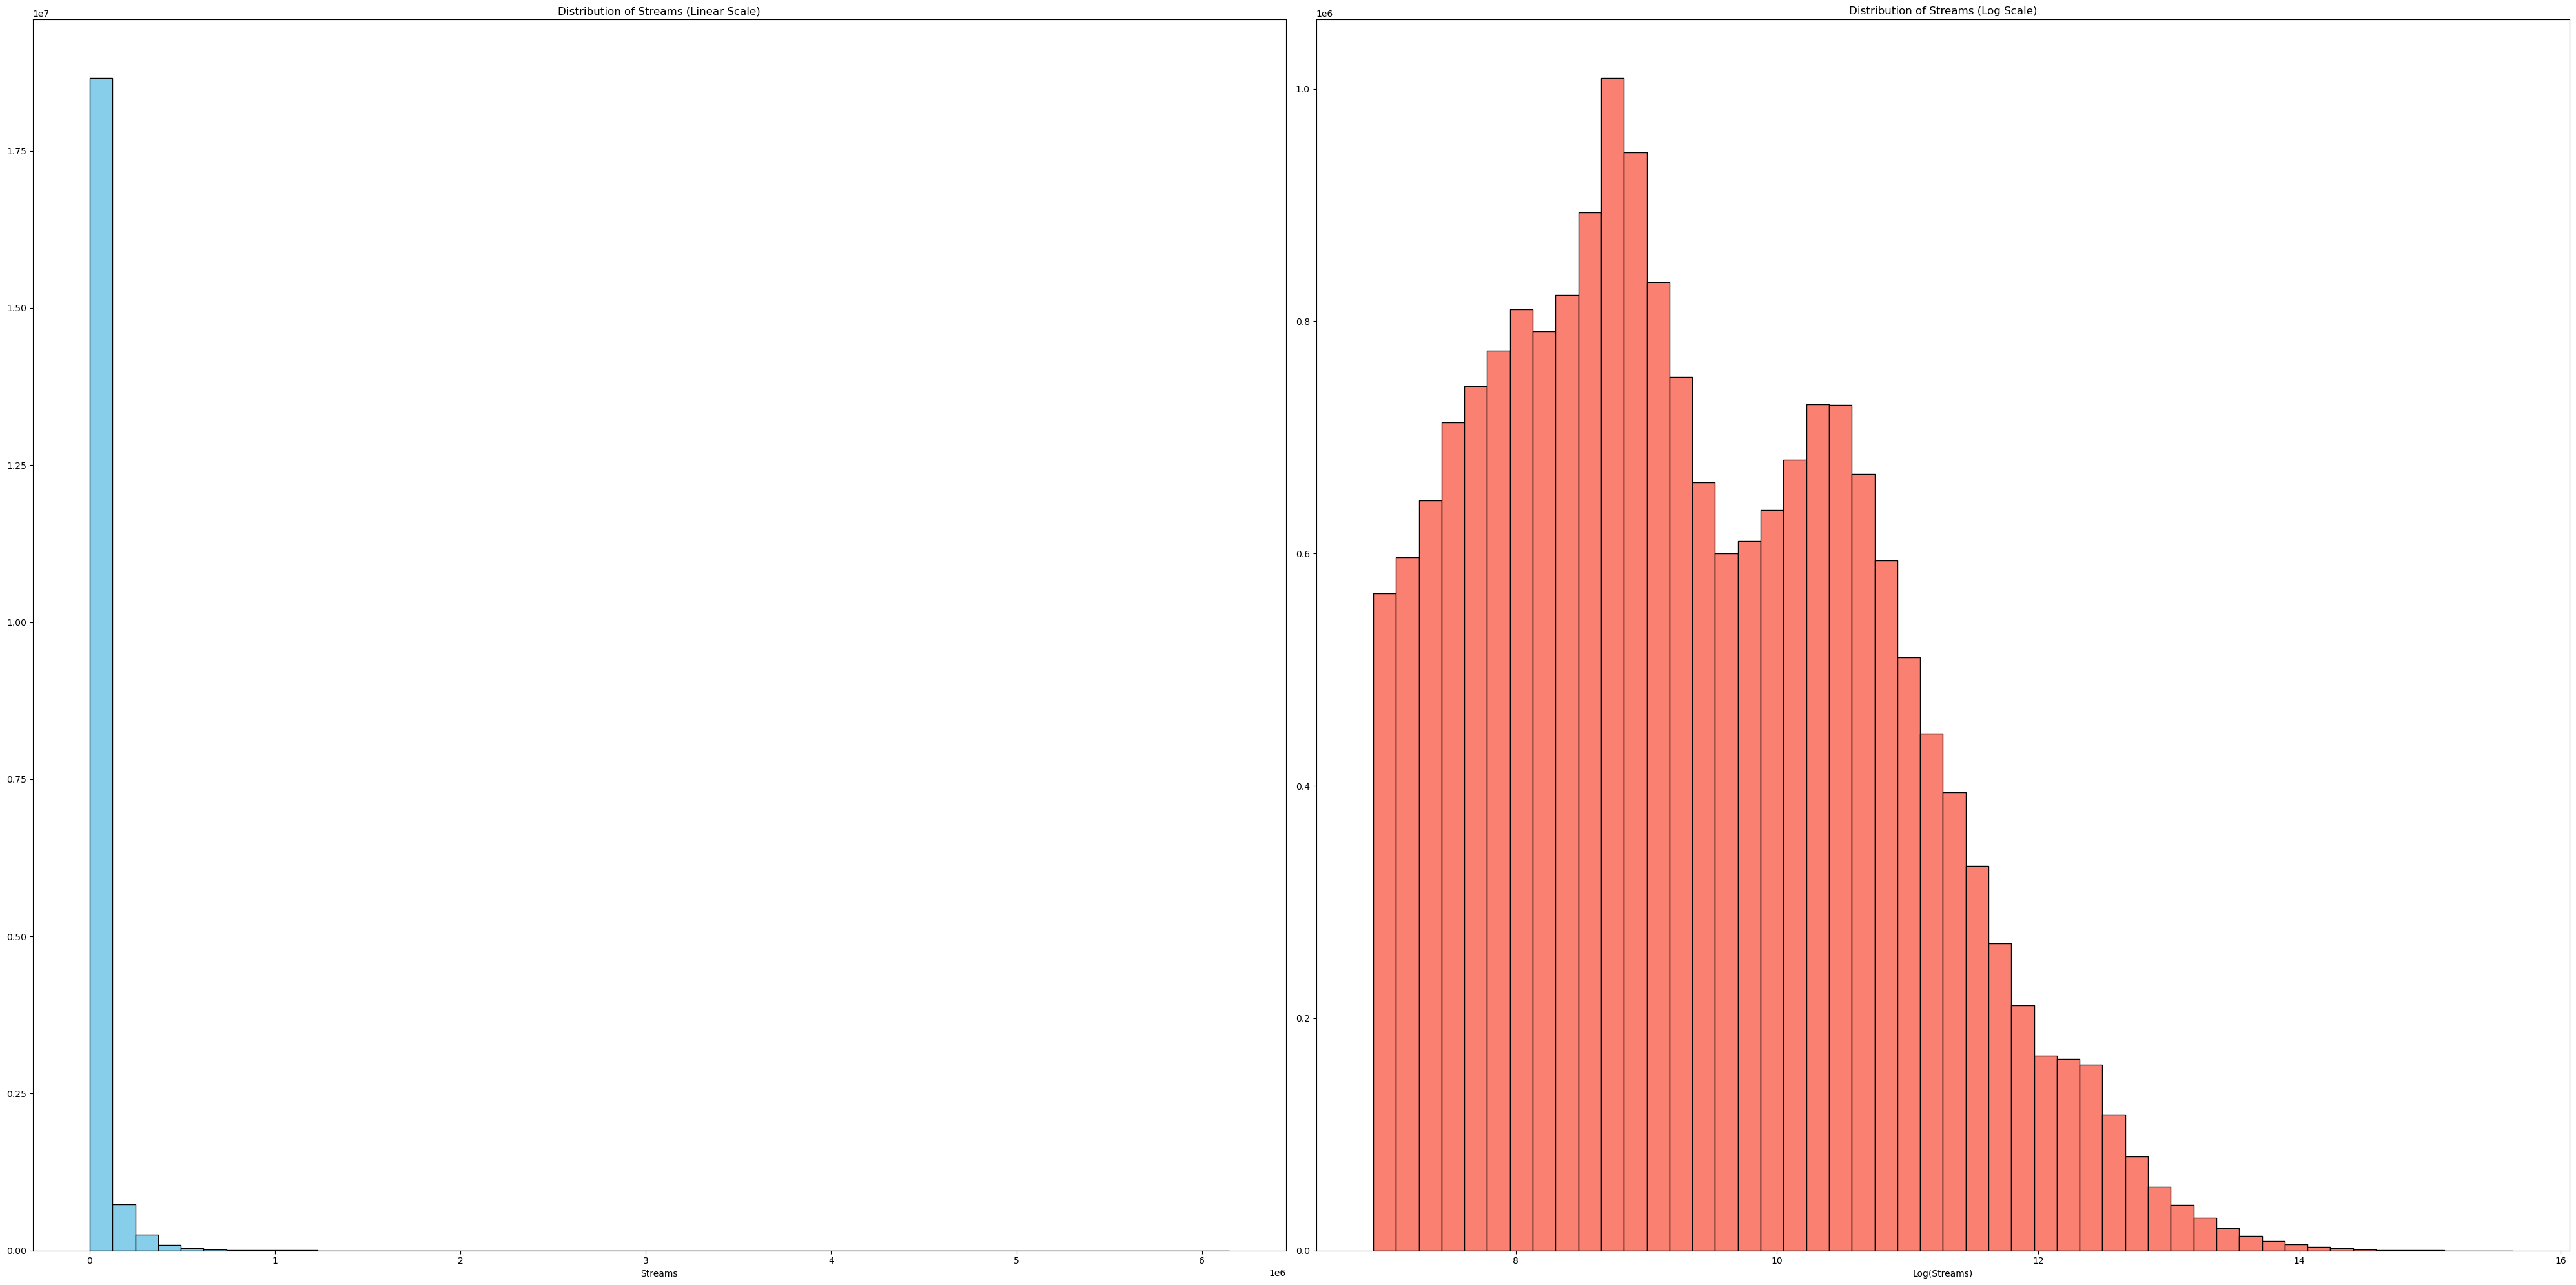

In [61]:
# Sample the data for visualization (as the dataset is too big for full pandas plotting)
sample_df = con.execute("SELECT TRY_CAST(streams AS DOUBLE) as streams FROM spotify_full WHERE streams IS NOT NULL AND LOWER (region) != 'global' USING SAMPLE 26000000").df()

plt.figure(figsize=(40, 20))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution 
plt.subplot(1, 2, 2)
plt.hist(np.log1p(sample_df['streams']), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()

These are all daily streams mapped accross countries. The distribution is heavily skewed because some songs are played 6 million times e.g. Drake in the US while most entries are from smaller countries where streams are significantly lower e.g., Andorra. See the distribution below. 

## Percentiles analysis of streams

── Stream value percentiles (full dataset) ──────────────────


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p50,p90,p95,p99,p999,max_streams
0,9201.0,81240.0,141359.0,355946.44,909675.222,6146233.0



── Top 20 highest-stream entries ────────────────────────────


,date,title,artist,region,chart,rank,streams,year
0,2021-09-03,Girls Want Girls (with Lil Baby),Drake,United States,top200,1,6146233,2021
1,2021-01-12,drivers license,Olivia Rodrigo,United States,top200,1,6145601,2021
2,2021-09-03,Champagne Poetry,Drake,United States,top200,2,5953619,2021
3,2018-06-29,Nonstop,Drake,United States,top200,1,5749019,2018
4,2021-01-13,drivers license,Olivia Rodrigo,United States,top200,1,5723851,2021
5,2021-01-11,drivers license,Olivia Rodrigo,United States,top200,1,5688246,2021
6,2021-09-03,Fair Trade (with Travis Scott),Drake,United States,top200,3,5616734,2021
7,2021-10-15,Easy On Me,Adele,United States,top200,1,5435431,2021
8,2021-01-14,drivers license,Olivia Rodrigo,United States,top200,1,5271136,2021
9,2018-06-29,Survival,Drake,United States,top200,2,5219711,2018



── Entries above stream thresholds ──────────────────────────
  streams >    6,000,000 :        2 entries
  streams >    3,000,000 :      275 entries
  streams >    1,000,000 :   15,037 entries
  streams >      500,000 :   94,398 entries

── Histogram of streams above the 99th percentile ──────────


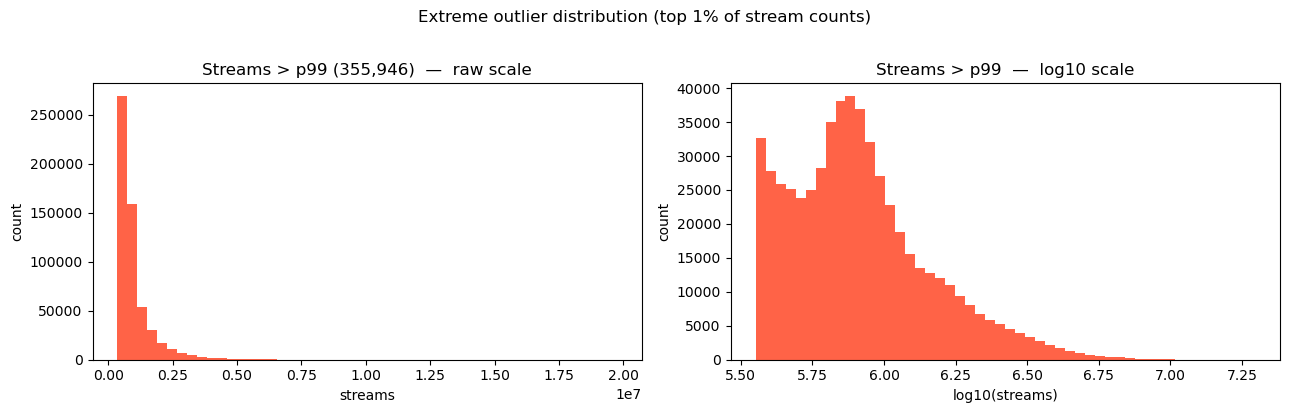


Note: The bulk of data sits around 9,201 streams (median).
The very top entries reach 6,146,233 streams — ~668× the median.


In [79]:
# Investigate extreme outliers driving the right-skewed histogram 
from IPython.display import clear_output
clear_output(wait=True)
# 1. Key percentiles to see where the tail starts
print("── Stream value percentiles (full dataset) ──────────────────")
pcts = con.execute("""
    SELECT
        PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p50,
        PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p90,
        PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p95,
        PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p99,
        PERCENTILE_CONT(0.999) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p999,
        MAX(TRY_CAST(streams AS DOUBLE)) AS max_streams
    FROM spotify_full
    WHERE streams IS NOT NULL AND LOWER(region) != 'global'
""").df()
display(pcts)

# 2. Top 20 individual entries by stream count
print("\n── Top 20 highest-stream entries ────────────────────────────")
top20 = con.execute("""
    SELECT
        date,
        title,
        artist,
        region,
        chart,
        TRY_CAST(rank    AS INTEGER) AS rank,
        TRY_CAST(streams AS BIGINT)  AS streams,
        year
    FROM spotify_full
    WHERE streams IS NOT NULL AND LOWER(region) != 'global'
    ORDER BY TRY_CAST(streams AS DOUBLE) DESC
    LIMIT 20
""").df()
display(top20)

# 3. How many entries exceed common "suspicious" thresholds?
print("\n── Entries above stream thresholds ──────────────────────────")
thresholds = [6_000_000, 3_000_000, 1_000_000, 500_000]
for t in thresholds:
    n = con.execute(f"""
        SELECT COUNT(*) FROM spotify_full
        WHERE TRY_CAST(streams AS DOUBLE) > {t} AND LOWER(region) != 'global'
    """).fetchone()[0]
    print(f"  streams > {t:>12,} : {n:>8,} entries")

# 4. Distribution of the top 1% visually
print("\n── Histogram of streams above the 99th percentile ──────────")
p99_val = float(pcts["p99"].iloc[0])
top1pct = con.execute(f"""
    SELECT TRY_CAST(streams AS DOUBLE) AS streams
    FROM spotify_full
    WHERE TRY_CAST(streams AS DOUBLE) > {p99_val}
      AND streams IS NOT NULL 
""").df()

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(top1pct["streams"], bins=50, color="tomato", edgecolor="none")
axes[0].set_title(f"Streams > p99 ({p99_val:,.0f})  —  raw scale")
axes[0].set_xlabel("streams")
axes[0].set_ylabel("count")

axes[1].hist(np.log10(top1pct["streams"]), bins=50, color="tomato", edgecolor="none")
axes[1].set_title("Streams > p99  —  log10 scale")
axes[1].set_xlabel("log10(streams)")
axes[1].set_ylabel("count")

plt.suptitle("Extreme outlier distribution (top 1% of stream counts)", y=1.02)
plt.tight_layout()
plt.show()

print(f"\nNote: The bulk of data sits around {float(pcts['p50'].iloc[0]):,.0f} streams (median).")
print(f"The very top entries reach {int(pcts['max_streams'].iloc[0]):,} streams — "
      f"~{int(pcts['max_streams'].iloc[0]) / float(pcts['p50'].iloc[0]):.0f}× the median.")

The skewed data seems plausible. These are the highest streamed songs. 

## Highest streams in a single country e.g., Germany 

In [80]:
print("\n Top 20 highest-stream entries:")
top20 = con.execute("""
    SELECT
        date,
        title,
        artist,
        region,
        chart,
        TRY_CAST(rank    AS INTEGER) AS rank,
        TRY_CAST(streams AS BIGINT)  AS streams,
        year
    FROM spotify_full
    WHERE streams IS NOT NULL AND LOWER(region) = 'germany' AND date = '2017-01-03'
    ORDER BY TRY_CAST(streams AS DOUBLE) DESC
    LIMIT 200
""").df()
display(top20)


── Top 20 highest-stream entries ────────────────────────────


,date,title,artist,region,chart,rank,streams,year
0,2017-01-03,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,Germany,top200,1,251496,2017
1,2017-01-03,I Don’t Wanna Live Forever (Fifty Shades Darke...,"ZAYN, Taylor Swift",Germany,top200,2,221842,2017
2,2017-01-03,Alone,Alan Walker,Germany,top200,3,220708,2017
3,2017-01-03,Starboy,"The Weeknd, Daft Punk",Germany,top200,4,202324,2017
4,2017-01-03,Shed a Light,"Robin Schulz, David Guetta, Cheat Codes",Germany,top200,5,197148,2017
...,...,...,...,...,...,...,...,...
195,2017-01-03,Lean On (feat. MØ & DJ Snake),Major Lazer,Germany,top200,196,24732,2017
196,2017-01-03,"Boom (feat. MOTi, TY Dolla $ign, Wizkid & Kran...",Major Lazer,Germany,top200,197,24700,2017
197,2017-01-03,Stresserblick 2 (feat. Kurdo),Majoe,Germany,top200,198,24584,2017
198,2017-01-03,24 Karat,Kollegah,Germany,top200,199,24446,2017


## Null (or less than 1) values

In [ ]:
# Count entries with 0 or NULL streams
stream_quality = con.execute("""
    SELECT
        COUNT(*)                                                          AS total_rows,
        SUM(CASE WHEN streams IS NULL THEN 1 ELSE 0 END)                 AS null_streams,
        SUM(CASE WHEN TRY_CAST(streams AS DOUBLE) = 0 THEN 1 ELSE 0 END) AS zero_streams,
        SUM(CASE WHEN streams IS NULL
                  OR TRY_CAST(streams AS DOUBLE) = 0 THEN 1 ELSE 0 END)  AS null_or_zero_streams
    FROM spotify_full
""").df()

total = stream_quality["total_rows"][0]
null_s  = stream_quality["null_streams"][0]
zero_s  = stream_quality["zero_streams"][0]
noz_s   = stream_quality["null_or_zero_streams"][0]

print("═" * 50)
print("  STREAMS — NULL / ZERO ENTRY COUNT")
print("═" * 50)
print(f"  Total rows          : {total:>12,}")
print(f"  NULL streams        : {null_s:>12,}  ({null_s/total*100:.2f}%)")
print(f"  Zero streams        : {zero_s:>12,}  ({zero_s/total*100:.2f}%)")
print(f"  NULL or zero        : {noz_s:>12,}  ({noz_s/total*100:.2f}%)")
print(f"  Valid (>0) streams  : {total-noz_s:>12,}  ({(total-noz_s)/total*100:.2f}%)")
print("═" * 50)

══════════════════════════════════════════════════
  STREAMS — NULL / ZERO ENTRY COUNT
══════════════════════════════════════════════════
  Total rows          :   26,174,269
  NULL streams        :  5,852,308.0  (22.36%)
  Zero streams        :          0.0  (0.00%)
  NULL or zero        :  5,852,308.0  (22.36%)
  Valid (>0) streams  : 20,321,961.0  (77.64%)
══════════════════════════════════════════════════


There are 5 million entries with no streams, they should be deleted. I guess :)


In [ ]:
# Count entries with zero missing values (complete rows) 
schema_df = con.execute("DESCRIBE spotify_full").df()
all_cols  = schema_df["column_name"].tolist()

# Build a CASE expression that counts NULLs across all columns per row
null_count_expr = " + ".join(
    [f"CASE WHEN \"{c}\" IS NULL THEN 1 ELSE 0 END" for c in all_cols]
)

completeness = con.execute(f"""
    SELECT
        COUNT(*)                                                      AS total_rows,
        SUM(CASE WHEN ({null_count_expr}) = 0 THEN 1 ELSE 0 END)     AS complete_rows,
        SUM(CASE WHEN ({null_count_expr}) > 0 THEN 1 ELSE 0 END)     AS rows_with_any_null,
        AVG(CASE WHEN ({null_count_expr}) = 0 THEN 1.0 ELSE 0.0 END) AS complete_rate
    FROM spotify_full
""").df()

total    = int(completeness["total_rows"][0])
complete = int(completeness["complete_rows"][0])
any_null = int(completeness["rows_with_any_null"][0])
rate     = float(completeness["complete_rate"][0])

print("═" * 55)
print("  ROW COMPLETENESS — zero missing values")
print("═" * 55)
print(f"  Total rows              : {total:>12,}")
print(f"  Complete rows (0 nulls) : {complete:>12,}  ({rate*100:.2f}%)")
print(f"  Rows with ≥1 null       : {any_null:>12,}  ({(1-rate)*100:.2f}%)")
print("═" * 55)

# Breakdown: how many nulls per row (distribution) 
print("\n── Distribution of null-count-per-row ────────────────────────")
null_dist = con.execute(f"""
    SELECT
        ({null_count_expr}) AS n_nulls_in_row,
        COUNT(*)             AS n_rows
    FROM spotify_full
    GROUP BY n_nulls_in_row
    ORDER BY n_nulls_in_row
""").df()
display(null_dist)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

═══════════════════════════════════════════════════════
  ROW COMPLETENESS — zero missing values
═══════════════════════════════════════════════════════
  Total rows              :   26,174,269
  Complete rows (0 nulls) :   16,423,650  (62.75%)
  Rows with ≥1 null       :    9,750,619  (37.25%)
═══════════════════════════════════════════════════════

── Distribution of null-count-per-row ────────────────────────


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_nulls_in_row,n_rows
0,0,16423650
1,1,4428366
2,2,2601
3,3,4
4,7,3159976
5,8,962274
6,9,554
7,14,719359
8,15,173128
9,16,106


Remove rows that have missing values. 

## Duplicates 

In [66]:
# Check for duplicate entries (same song, country, date, chart)
print("  DUPLICATE CHECK — (track_id, region, date, chart)")
print("═" * 60)

# 1. Total rows vs distinct combinations
totals = con.execute("""
    SELECT
        COUNT(*) AS total_rows,
        COUNT(DISTINCT (track_id, region, date, chart)) AS distinct_combinations
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
""").df()

total     = int(totals["total_rows"][0])
distinct  = int(totals["distinct_combinations"][0])
dupes     = total - distinct

print(f"\n  Total rows (excl. NULL streams/track_id) : {total:>12,}")
print(f"  Distinct combinations                    : {distinct:>12,}")
print(f"  Duplicate rows                           : {dupes:>12,}  ({dupes/total*100:.2f}%)")

# 2. Top 20 most duplicated combinations
print("\n── Top 20 most duplicated (track_id, region, date, chart) ──")
top_dupes = con.execute("""
    SELECT
        track_id,
        region,
        date,
        chart,
        COUNT(*) AS n_entries,
        MIN(TRY_CAST(streams AS BIGINT)) AS streams_min,
        MAX(TRY_CAST(streams AS BIGINT)) AS streams_max
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
    GROUP BY track_id, region, date, chart
    HAVING COUNT(*) > 1
    ORDER BY n_entries DESC
""").df()

if top_dupes.empty:
    print("No duplicates found!")
else:
    print(f"{len(top_dupes):,} duplicate groups found (showing top 20)")
    display(top_dupes)

# 3. Are stream values identical across duplicates, or do they differ?
print("\n── Do duplicate rows have conflicting stream values? ────────")
conflict_check = con.execute("""
    SELECT
        COUNT(*) AS groups_with_conflicting_streams
    FROM (
        SELECT track_id, region, date, chart
        FROM spotify_full
        WHERE streams IS NOT NULL
          AND track_id IS NOT NULL
        GROUP BY track_id, region, date, chart
        HAVING COUNT(*) > 1
          AND MIN(TRY_CAST(streams AS BIGINT)) != MAX(TRY_CAST(streams AS BIGINT))
    )
""").fetchone()[0]

if conflict_check == 0:
    print("All duplicate rows have identical stream values (safe to deduplicate).")
else:
    print(f"{conflict_check:,} groups have DIFFERENT stream values — inspect before dropping!")

  DUPLICATE CHECK — (track_id, region, date, chart)
════════════════════════════════════════════════════════════

  Total rows (excl. NULL streams/track_id) :   20,318,921
  Distinct combinations                    :   20,318,864
  Duplicate rows                           :           57  (0.00%)

── Top 20 most duplicated (track_id, region, date, chart) ──


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

57 duplicate groups found (showing top 20)


,track_id,region,date,chart,n_entries,streams_min,streams_max
0,4hGyLmElEHdBf29ubQ61Yq,Peru,2017-10-10,top200,2,24820,24820
1,4hGyLmElEHdBf29ubQ61Yq,Peru,2017-11-18,top200,2,6406,6406
2,3JGE1pWIf4Z6JqjIz6f1F4,Germany,2017-09-01,top200,2,81942,81942
3,3ZVrELQ8ncJNY0K6oWgHSB,Taiwan,2017-09-01,top200,2,2552,2552
4,6w40GgWhGts8g6779DPXR3,Israel,2018-03-14,top200,2,1232,1232
5,7mIFzHyC5luAXh0jIMj6XY,Ireland,2017-09-01,top200,2,3746,3746
6,5RwZ97IdwhGxQWsvSXBokl,Paraguay,2017-09-02,top200,2,1621,1621
7,4Rg9TAzx7mq7MEmEFdQzIb,Belgium,2017-09-06,top200,2,5147,5147
8,4hGyLmElEHdBf29ubQ61Yq,Peru,2017-11-16,top200,2,24225,24225
9,7mIFzHyC5luAXh0jIMj6XY,Malaysia,2017-09-01,top200,2,3316,3316



── Do duplicate rows have conflicting stream values? ────────


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

All duplicate rows have identical stream values (safe to deduplicate).


57 entries are duplicated i.e. they have the same track_id, country, date and chart. The streams are equivalent so its safe to delete them.

## 8)Descriptive Analysis of Cross-Market Behavior

## 8.1) Country Analysis

════════════════════════════════════════════════════════════
  AVERAGE STREAMS PER COUNTRY
════════════════════════════════════════════════════════════

  Total countries: 68


,region,n_entries,avg_streams,median_streams,max_streams,total_streams
0,United States,364081,390255.989208,294790.0,6146233,1.420848e+11
1,Brazil,364503,153263.777791,111785.0,2001683,5.586511e+10
2,Mexico,358331,127242.997592,97308.0,3680758,4.559511e+10
3,Germany,357342,111799.026311,80791.5,2629922,3.995049e+10
4,United Kingdom,359715,101198.344323,70095.0,2801638,3.640256e+10
...,...,...,...,...,...,...
63,Lithuania,152993,1938.003046,1520.0,86013,2.965009e+08
64,Estonia,107995,1790.969452,1486.0,29525,1.934157e+08
65,Latvia,150974,1728.479407,1448.0,23558,2.609554e+08
66,Bulgaria,94834,1707.914661,1401.0,30203,1.619684e+08


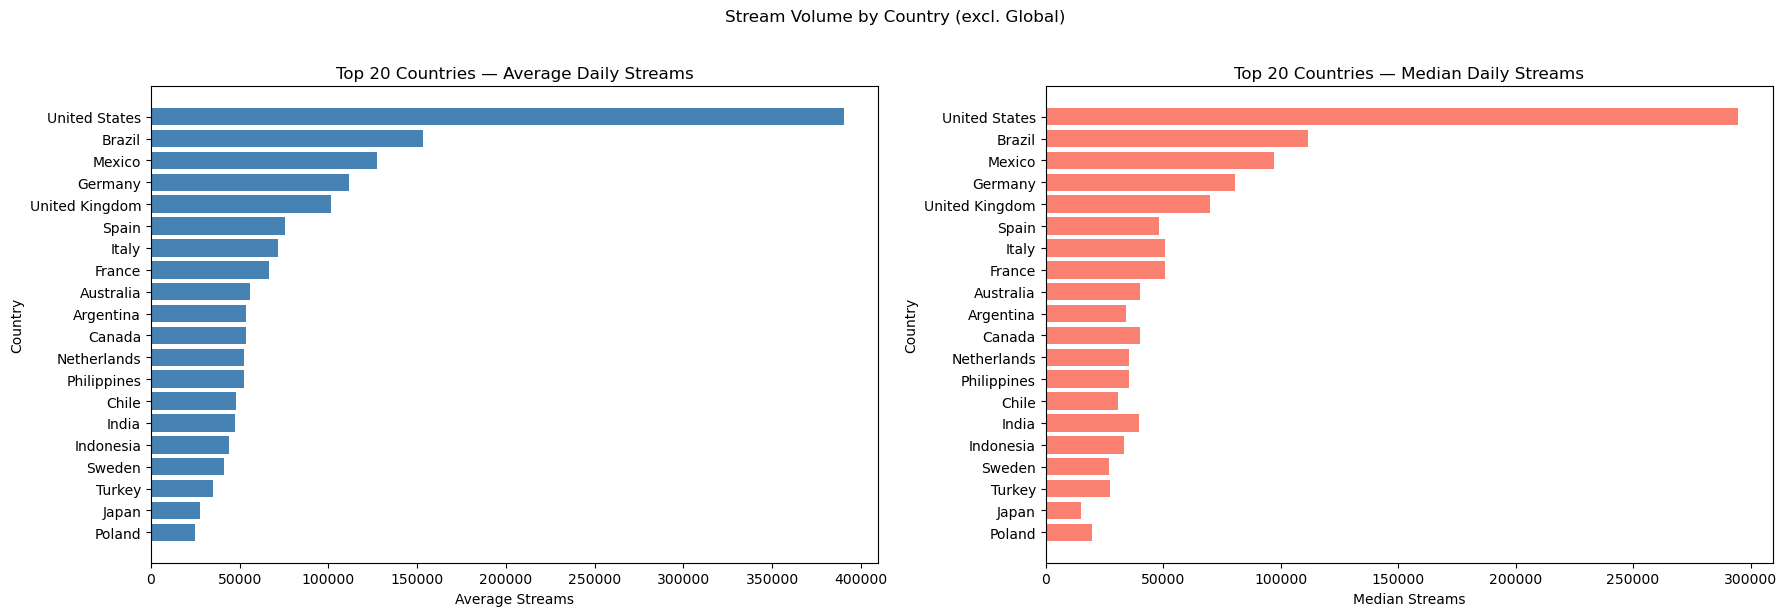


── Bottom 10 countries by average streams ───────────────────


,region,n_entries,avg_streams,median_streams,max_streams,total_streams
58,Egypt,123764,2551.200398,1936.0,74586,315746766.0
59,Slovakia,267583,2421.919012,1893.0,39470,648064355.0
60,United Arab Emirates,142051,2147.140823,1649.0,27573,305003501.0
61,Iceland,212061,2100.610112,1545.0,44069,445457481.0
62,Nicaragua,109995,2065.814528,1565.0,34289,227229269.0
63,Lithuania,152993,1938.003046,1520.0,86013,296500900.0
64,Estonia,107995,1790.969452,1486.0,29525,193415746.0
65,Latvia,150974,1728.479407,1448.0,23558,260955450.0
66,Bulgaria,94834,1707.914661,1401.0,30203,161968379.0
67,Luxembourg,8957,1658.866362,1386.0,16701,14858466.0


In [67]:
# Average streams per country (excluding global) 
print("═" * 60)
print("  AVERAGE STREAMS PER COUNTRY")
print("═" * 60)

avg_streams_country = con.execute("""
    SELECT
        region,
        COUNT(*)                                          AS n_entries,
        AVG(TRY_CAST(streams AS DOUBLE))                 AS avg_streams,
        MEDIAN(TRY_CAST(streams AS DOUBLE))              AS median_streams,
        MAX(TRY_CAST(streams AS BIGINT))                 AS max_streams,
        SUM(TRY_CAST(streams AS BIGINT))                 AS total_streams
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY region
    ORDER BY avg_streams DESC
""").df()

print(f"\n  Total countries: {len(avg_streams_country):,}")
display(avg_streams_country)

# Bar chart: Top 20 countries by average streams 
top20 = avg_streams_country.head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Average streams
axes[0].barh(top20["region"][::-1], top20["avg_streams"][::-1], color="steelblue")
axes[0].set_title("Top 20 Countries — Average Daily Streams")
axes[0].set_xlabel("Average Streams")
axes[0].set_ylabel("Country")

# Median streams (less affected by outliers)
axes[1].barh(top20["region"][::-1], top20["median_streams"][::-1], color="salmon")
axes[1].set_title("Top 20 Countries — Median Daily Streams")
axes[1].set_xlabel("Median Streams")
axes[1].set_ylabel("Country")

plt.suptitle("Stream Volume by Country (excl. Global)", y=1.02)
plt.tight_layout()
plt.show()

# Bottom 10 countries by average streams 
print("\n── Bottom 10 countries by average streams ───────────────────")
display(avg_streams_country.tail(10))

## Country-Level Stream Analysis – Key Findings

The country analysis reveals strong heterogeneity in average and median daily streams across markets. The United States dominates by a large margin, followed by Brazil, Mexico, Germany, and the United Kingdom. These markets show substantially higher stream volumes compared to smaller European countries such as Luxembourg, Bulgaria, or Latvia.

The gap between mean and median streams suggests that larger markets are more influenced by viral outliers, whereas smaller markets exhibit more stable but lower stream distributions. The observed differences in stream volume are consistent with variations in population size and overall platform penetration, indicating that structural market characteristics play an important role.

Overall, these findings indicate that international rollout decisions cannot treat countries uniformly. Market-specific dynamics significantly influence stream performance, reinforcing the importance of a data-driven system that ranks target markets based on expected impact and timing.

## 8.2) Artist Analysis

## Artist Analysis

═════════════════════════════════════════════════════════════════
  1) BIGGEST ARTISTS IN THE DATA
═════════════════════════════════════════════════════════════════

  Total unique artists: 39,890

── Top 20 artists by chart appearances ──────────────────────


,artist,chart_appearances,unique_songs,countries_reached,active_days,avg_rank,total_streams
0,Ed Sheeran,355703,123,68,1823,95.7,1.051741e+10
1,Billie Eilish,222671,67,68,1404,93.7,7.527774e+09
2,Post Malone,189243,71,68,1823,88.7,9.338347e+09
3,Bad Bunny,184950,62,65,1823,84.0,5.150676e+09
4,Dua Lipa,169748,47,68,1823,82.9,5.605296e+09
5,Ariana Grande,169097,90,68,1823,85.9,7.015974e+09
6,Drake,150884,153,68,1822,83.4,8.866556e+09
7,Imagine Dragons,139994,89,68,1823,102.6,3.223163e+09
8,XXXTENTACION,135503,62,66,1797,108.9,5.499213e+09
9,The Weeknd,130631,59,68,1705,71.4,5.750073e+09



── Top 20 artists by unique songs ───────────────────────────


,artist,chart_appearances,unique_songs,countries_reached,active_days,avg_rank,total_streams
394,Jul,8003,257,5,1589,109.6,4.728192e+08
10,BTS,130056,230,68,1823,94.2,3.381890e+09
20,Taylor Swift,83198,214,68,1667,100.3,3.928982e+09
93,TWICE,27775,171,33,1810,105.7,5.045369e+08
6,Drake,150884,153,68,1822,83.4,8.866556e+09
8679,Die drei ???,179,138,1,35,166.0,9.696489e+06
13,Juice WRLD,106780,123,68,1351,100.9,6.363268e+09
0,Ed Sheeran,355703,123,68,1823,95.7,1.051741e+10
722,Djadja & Dinaz,4710,121,4,1468,113.4,2.466783e+08
733,Tory Lanez,4650,116,42,1070,126.3,2.896469e+08


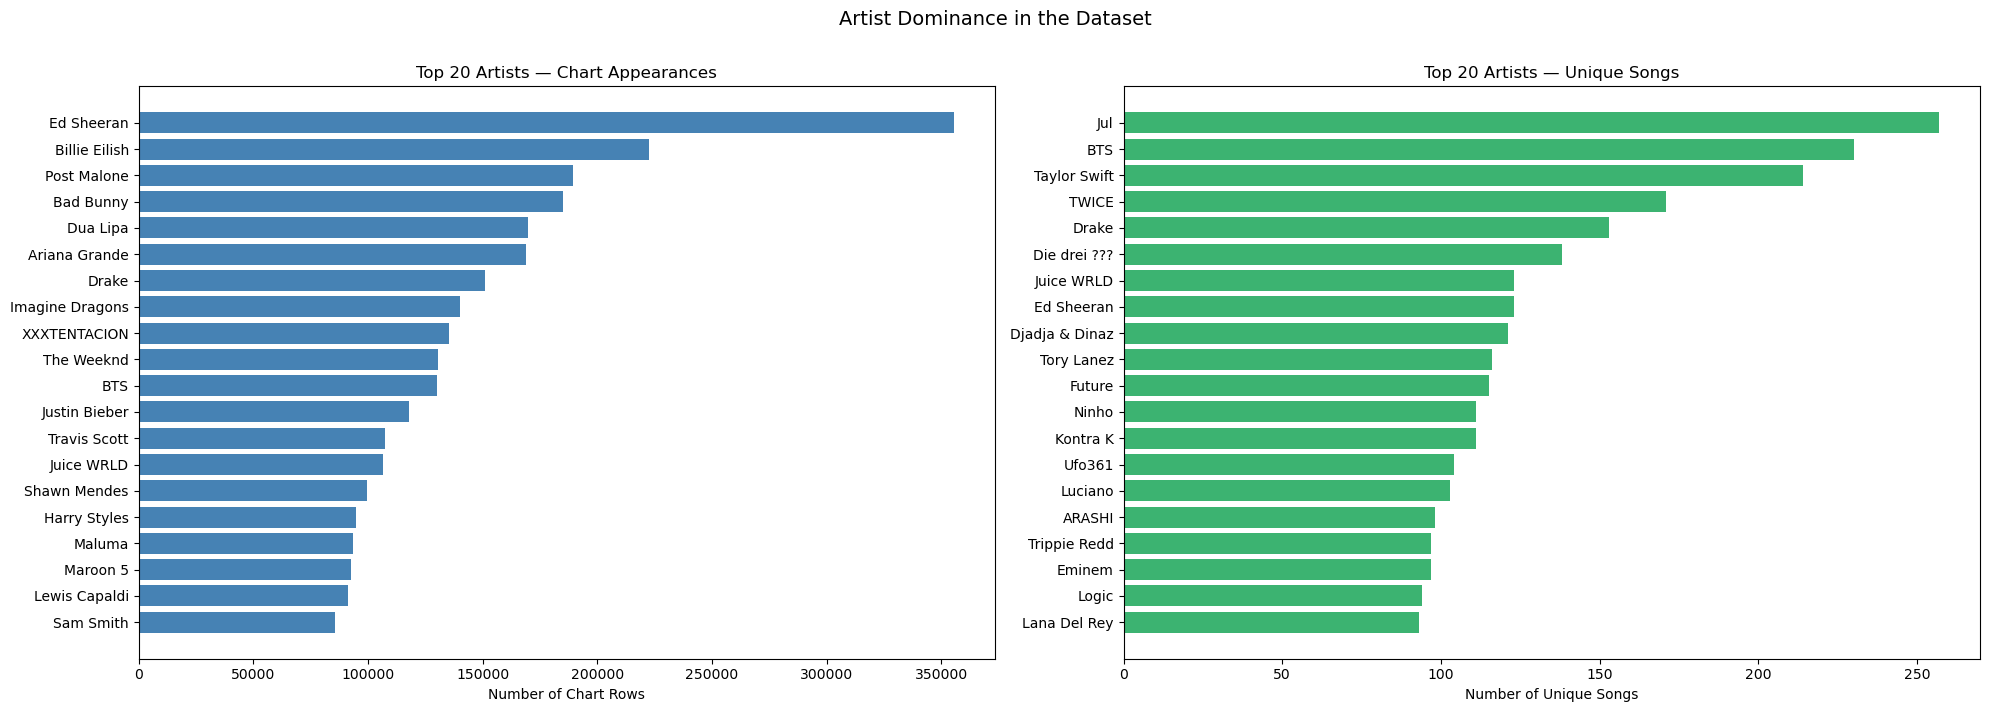

In [68]:
# 1. TOP ARTISTS BY CHART APPEARANCES & UNIQUE SONGS
print("═" * 65)
print("  1) BIGGEST ARTISTS IN THE DATA")
print("═" * 65)

top_artists_appearances = con.execute("""
    SELECT
        artist,
        COUNT(*)                        AS chart_appearances,
        COUNT(DISTINCT track_id)        AS unique_songs,
        COUNT(DISTINCT region)          AS countries_reached,
        COUNT(DISTINCT date)            AS active_days,
        ROUND(AVG(TRY_CAST(rank AS DOUBLE)), 1)    AS avg_rank,
        SUM(TRY_CAST(streams AS BIGINT))            AS total_streams
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND artist IS NOT NULL
      AND track_id IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY artist
    ORDER BY chart_appearances DESC
""").df()

print(f"\n  Total unique artists: {len(top_artists_appearances):,}")
print("\n── Top 20 artists by chart appearances ──────────────────────")
display(top_artists_appearances.head(20))

print("\n── Top 20 artists by unique songs ───────────────────────────")
display(top_artists_appearances.sort_values("unique_songs", ascending=False).head(20))

# Plot: Top 20 by appearances vs unique songs
top20_app  = top_artists_appearances.head(20)
top20_songs = top_artists_appearances.sort_values("unique_songs", ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].barh(top20_app["artist"][::-1], top20_app["chart_appearances"][::-1], color="steelblue")
axes[0].set_title("Top 20 Artists — Chart Appearances")
axes[0].set_xlabel("Number of Chart Rows")

axes[1].barh(top20_songs["artist"][::-1], top20_songs["unique_songs"][::-1], color="mediumseagreen")
axes[1].set_title("Top 20 Artists — Unique Songs")
axes[1].set_xlabel("Number of Unique Songs")

plt.suptitle("Artist Dominance in the Dataset", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

## Artist Level Analysis – Key Findings

The artist analysis shows strong concentration in chart dominance: although nearly 40,000 artists appear in the dataset, a small group of globally established artists accounts for a disproportionately large share of chart appearances and country reach. Top artists consistently chart across many countries and maintain long chart presence, while others show more localized or short-lived performance. There is substantial variability in the number of countries reached and the number of unique songs charting per artist. These differences highlight the importance of incorporating artist-level characteristics, such as prior chart history and international reach, when predicting cross-border breakout potential and rollout timing.

## 8.3) Song Travel Patterns — How Do Songs Spread Across Countries?

For each song we find its **first chart date per country**, then measure:
- **Days to spread**: how many days after the first-ever chart appearance does the song enter each new country
- **Speed of spread**: how quickly the top songs travel globally
- **Origin country**: which country a song typically charts in first
- **Spread width**: how many countries a song eventually reaches


Computing first chart date per track per country … (may take a moment)
  Rows (track × country × chart): 359,369
  Songs tracked : 117,876
  Median days to arrive in a new country: 12 days
  Mean   days to arrive in a new country: 102.4 days

═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
═
  SPREAD WIDTH — songs by countries reached
════════════════════════════════
  Median countries reached per song : 1
  Mean   countries reached per song : 3.0
  Songs reaching ≥ 30 countries     : 2,475
  Songs reaching ≥ 50 countries     : 943


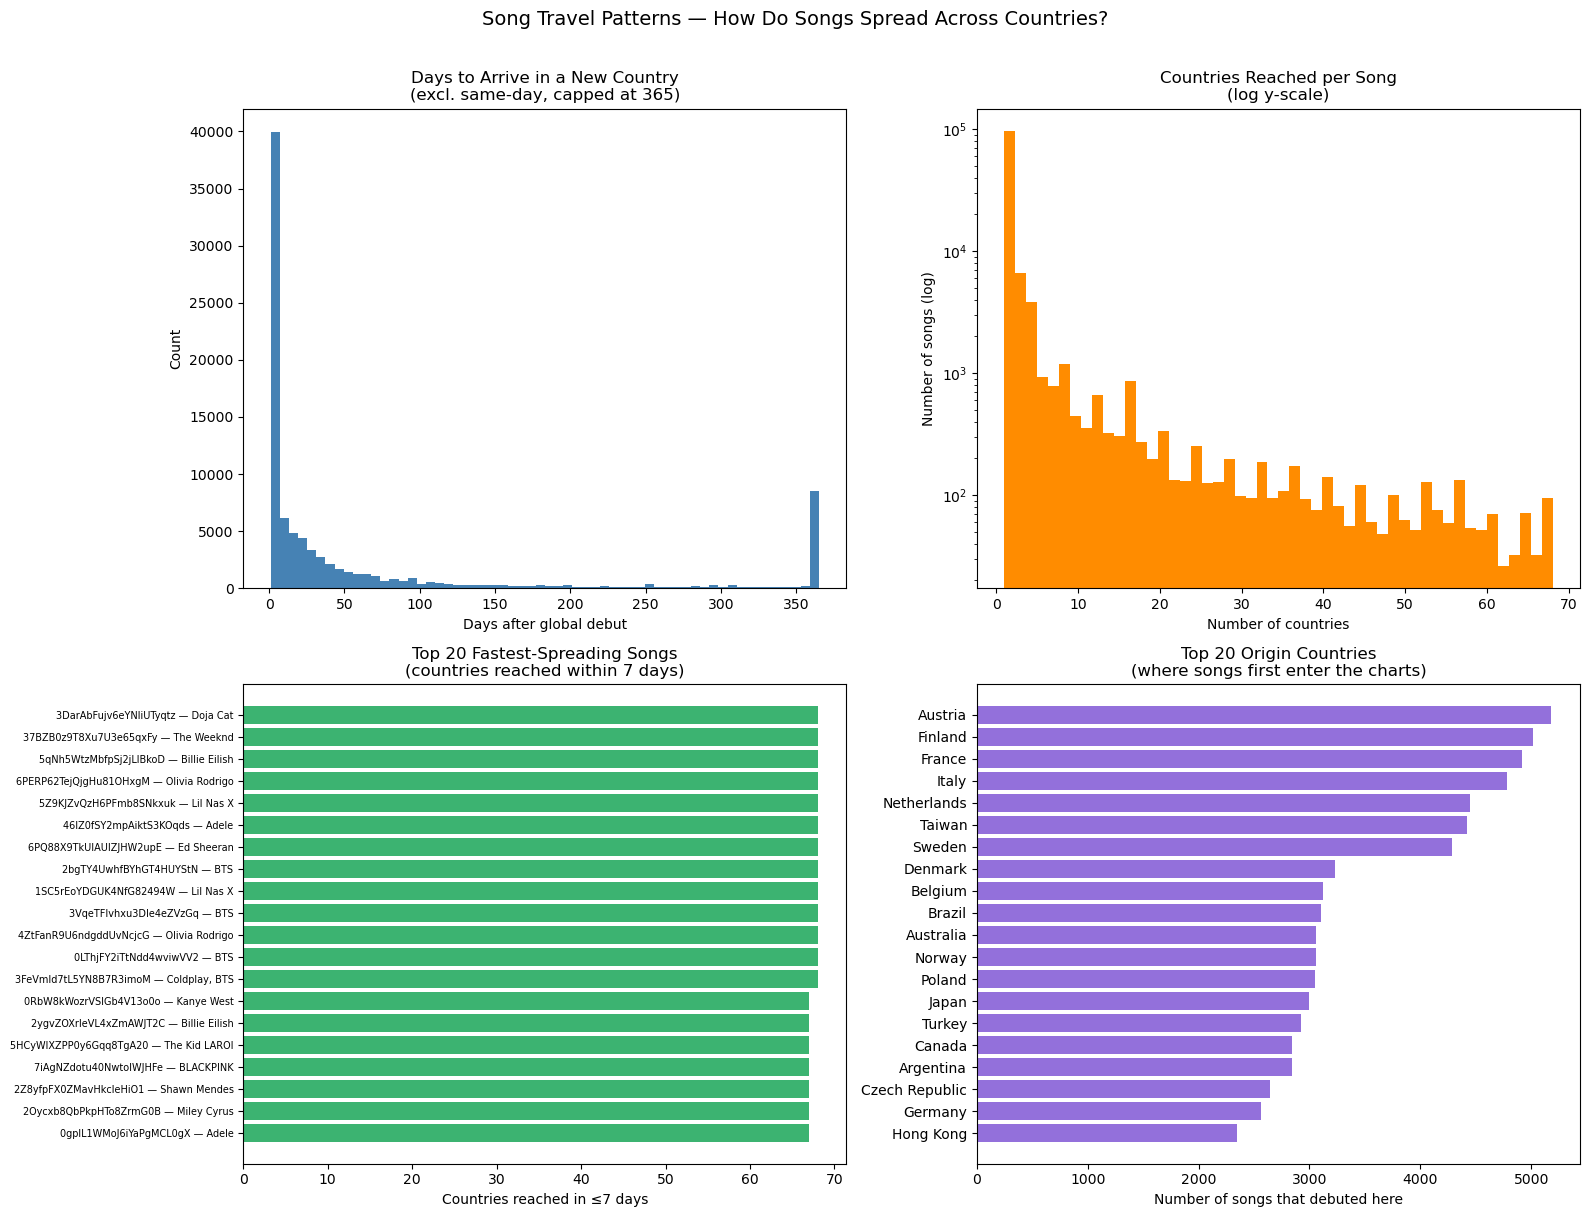


── Top 20 widest-spreading songs (most countries reached) ───


,artist,origin_country,countries_reached,days_to_50pct,max_spread_days
0,Lady Gaga,Argentina,68,0.0,250
1,BLACKPINK,Argentina,68,0.0,122
2,Doja Cat,United States,68,24.5,421
3,Ariana Grande,Argentina,68,0.0,94
4,BTS,Argentina,68,0.0,0
5,Dua Lipa,Argentina,68,0.0,311
6,Billie Eilish,Australia,68,0.0,81
7,Lil Nas X,Australia,68,0.0,42
8,Ariana Grande,Argentina,68,0.0,732
9,Doja Cat,Argentina,68,0.0,0



── Spread speed by chart type ───────────────────────────────


,chart,median_days,mean_days,n_arrivals
0,top200,12.0,102.4,90206


In [ ]:
# For each (track_id, region) pair, find the first date it appeared on any chart.
# Then compute how many days after the track's global debut it reached each country.

# Step 1: First chart date per (track_id, region) 
print("Computing first chart date per track per country … (may take a moment)")

first_entry = con.execute("""
    SELECT
        track_id,
        artist,
        region,
        chart,
        MIN(CAST(date AS DATE)) AS first_chart_date
    FROM spotify_full
    WHERE track_id  IS NOT NULL
      AND streams   IS NOT NULL
      AND region    IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY track_id, artist, region, chart
""").df()

first_entry["first_chart_date"] = pd.to_datetime(first_entry["first_chart_date"])
print(f"  Rows (track × country × chart): {len(first_entry):,}")

# Step 2: Global debut = earliest first_chart_date across all countries 
global_debut = (
    first_entry
    .groupby("track_id")["first_chart_date"]
    .min()
    .reset_index()
    .rename(columns={"first_chart_date": "global_debut"})
)

travel = first_entry.merge(global_debut, on="track_id")
travel["days_to_arrive"] = (travel["first_chart_date"] - travel["global_debut"]).dt.days

# Origin country = the country where days_to_arrive == 0
origin = (
    travel[travel["days_to_arrive"] == 0]
    .groupby("track_id")["region"]
    .agg(lambda x: x.mode().iloc[0])   # most common origin when tied
    .reset_index()
    .rename(columns={"region": "origin_country"})
)
travel = travel.merge(origin, on="track_id", how="left")

print(f"  Songs tracked : {travel['track_id'].nunique():,}")
print(f"  Median days to arrive in a new country: {travel[travel['days_to_arrive'] > 0]['days_to_arrive'].median():.0f} days")
print(f"  Mean   days to arrive in a new country: {travel[travel['days_to_arrive'] > 0]['days_to_arrive'].mean():.1f} days")

# Step 3: Spread width per song 
spread = (
    travel.groupby(["track_id", "artist", "origin_country"])
    .agg(
        countries_reached = ("region",          "nunique"),
        days_to_50pct     = ("days_to_arrive",  lambda x: x.quantile(0.5)),
        max_spread_days   = ("days_to_arrive",  "max"),
    )
    .reset_index()
)

print("\n" + "═" * 60)
print("  SPREAD WIDTH — songs by countries reached")
print("═" * 60)
print(f"  Median countries reached per song : {spread['countries_reached'].median():.0f}")
print(f"  Mean   countries reached per song : {spread['countries_reached'].mean():.1f}")
print(f"  Songs reaching ≥ 30 countries     : {(spread['countries_reached'] >= 30).sum():,}")
print(f"  Songs reaching ≥ 50 countries     : {(spread['countries_reached'] >= 50).sum():,}")

# Step 4: Visualisations 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Distribution of days_to_arrive (excluding same-day)
later = travel[travel["days_to_arrive"] > 0]["days_to_arrive"].clip(upper=365)
axes[0, 0].hist(later, bins=60, color="steelblue", edgecolor="none")
axes[0, 0].set_title("Days to Arrive in a New Country\n(excl. same-day, capped at 365)")
axes[0, 0].set_xlabel("Days after global debut")
axes[0, 0].set_ylabel("Count")

# (b) Distribution of spread width (# countries per song)
axes[0, 1].hist(spread["countries_reached"], bins=50, color="darkorange", edgecolor="none")
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Countries Reached per Song\n(log y-scale)")
axes[0, 1].set_xlabel("Number of countries")
axes[0, 1].set_ylabel("Number of songs (log)")

# (c) Top 20 fastest-spreading songs (most countries within 7 days)
fast = (
    travel[travel["days_to_arrive"] <= 7]
    .groupby(["track_id", "artist"])["region"]
    .nunique()
    .reset_index()
    .rename(columns={"region": "countries_in_7d"})
    .sort_values("countries_in_7d", ascending=False)
    .head(20)
)
axes[1, 0].barh(
    (fast["track_id"].str[:25] + " — " + fast["artist"].str[:15])[::-1],
    fast["countries_in_7d"][::-1],
    color="mediumseagreen"
)
axes[1, 0].set_title("Top 20 Fastest-Spreading Songs\n(countries reached within 7 days)")
axes[1, 0].set_xlabel("Countries reached in ≤7 days")
axes[1, 0].tick_params(axis="y", labelsize=7)

# (d) Top 20 most common origin countries (where songs chart first)
top_origins = (
    origin.merge(spread[["track_id"]], on="track_id")
    .groupby("origin_country")
    .size()
    .reset_index(name="n_songs_originated")
    .sort_values("n_songs_originated", ascending=False)
    .head(20)
)
axes[1, 1].barh(
    top_origins["origin_country"][::-1],
    top_origins["n_songs_originated"][::-1],
    color="mediumpurple"
)
axes[1, 1].set_title("Top 20 Origin Countries\n(where songs first enter the charts)")
axes[1, 1].set_xlabel("Number of songs that debuted here")

plt.suptitle("Song Travel Patterns — How Do Songs Spread Across Countries?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Step 5: Top 20 widest-spreading songs 
print("\n── Top 20 widest-spreading songs (most countries reached) ───")
display(
    spread.sort_values("countries_reached", ascending=False)
    .head(20)[["artist", "origin_country",
               "countries_reached", "days_to_50pct", "max_spread_days"]]
    .reset_index(drop=True)
)

# Step 6: Spread speed by chart type 
print("\n── Spread speed by chart type ───────────────────────────────")
chart_speed = (
    travel[travel["days_to_arrive"] > 0]
    .groupby("chart")["days_to_arrive"]
    .agg(["median", "mean", "count"])
    .round(1)
    .rename(columns={"median": "median_days", "mean": "mean_days", "count": "n_arrivals"})
    .sort_values("median_days")
    .reset_index()
)
display(chart_speed)


## Song Travel Analysis – Key Findings

Test here....

# EDA Continued

════════════════════════════════════════════════════════════
  SPREAD WIDTH PROPORTIONS
════════════════════════════════════════════════════════════

  Total songs analysed: 118,071

  Reach Tier                Songs        %   Cumulative %
  -------------------- ---------- -------- --------------
  1 country                86,347   73.13%         73.13%
  2–3 countries            17,810   15.08%         88.21%
  4–5 countries             3,809    3.23%         91.44%
  6–10 countries            3,354    2.84%         94.28%
  11–20 countries           3,158    2.67%         96.95%
  21–30 countries           1,217    1.03%         97.98%
  31–50 countries           1,496    1.27%         99.25%
  >50 countries               880    0.75%        100.00%


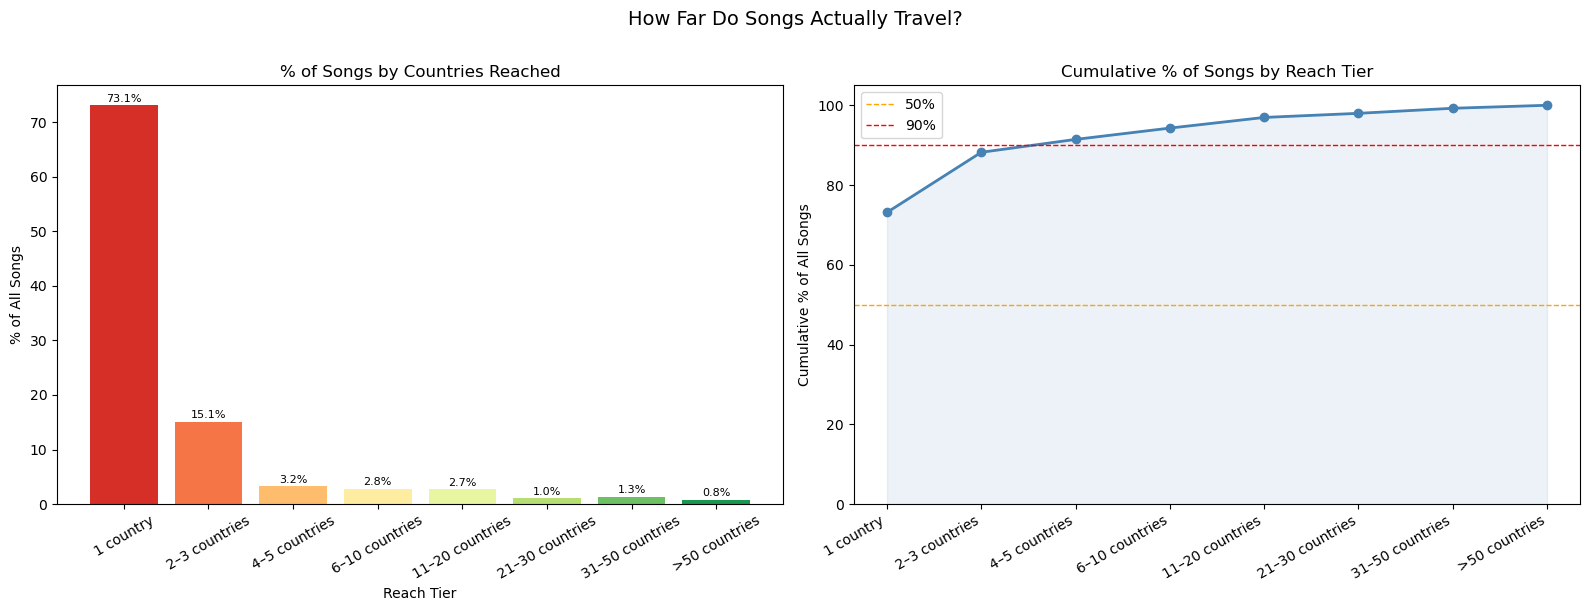


  Key takeaways:
  → 86,347 songs (73.1%) never left their first country
  → 2,376 songs (2.0%) reached more than 30 countries
  → Median reach: 1 countries
  → Mean reach  : 3.0 countries


In [82]:
# ── Spread Width Proportions — what % of songs reach how many countries ───────
print("═" * 60)
print("  SPREAD WIDTH PROPORTIONS")
print("═" * 60)

total_songs = len(spread)

# Define meaningful reach tiers
bins = [0, 1, 3, 5, 10, 20, 30, 50, float("inf")]
labels = ["1 country", "2–3 countries", "4–5 countries",
          "6–10 countries", "11–20 countries", "21–30 countries",
          "31–50 countries", ">50 countries"]

spread["reach_tier"] = pd.cut(
    spread["countries_reached"],
    bins=bins,
    labels=labels,
    right=True
)

tier_counts = (
    spread.groupby("reach_tier", observed=True)
    .size()
    .reset_index(name="n_songs")
)
tier_counts["pct"] = (tier_counts["n_songs"] / total_songs * 100).round(2)
tier_counts["cumulative_pct"] = tier_counts["pct"].cumsum().round(2)

print(f"\n  Total songs analysed: {total_songs:,}\n")
print(f"  {'Reach Tier':<20} {'Songs':>10} {'%':>8} {'Cumulative %':>14}")
print(f"  {'-'*20} {'-'*10} {'-'*8} {'-'*14}")
for _, row in tier_counts.iterrows():
    print(f"  {str(row['reach_tier']):<20} {int(row['n_songs']):>10,} {row['pct']:>7.2f}% {row['cumulative_pct']:>13.2f}%")

# ── Visualise ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.RdYlGn(np.linspace(0.1, 0.9, len(tier_counts)))

# Bar chart with % labels
bars = axes[0].bar(tier_counts["reach_tier"], tier_counts["pct"], color=colors, edgecolor="none")
axes[0].set_title("% of Songs by Countries Reached")
axes[0].set_xlabel("Reach Tier")
axes[0].set_ylabel("% of All Songs")
axes[0].tick_params(axis="x", rotation=30)
for bar, pct in zip(bars, tier_counts["pct"]):
    axes[0].text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 0.3,
                 f"{pct:.1f}%", ha="center", va="bottom", fontsize=8)

# Cumulative % line chart
axes[1].plot(tier_counts["reach_tier"], tier_counts["cumulative_pct"],
             marker="o", color="steelblue", linewidth=2)
axes[1].axhline(50,  color="orange", linestyle="--", linewidth=1, label="50%")
axes[1].axhline(90,  color="red",    linestyle="--", linewidth=1, label="90%")
axes[1].fill_between(range(len(tier_counts)), tier_counts["cumulative_pct"],
                     alpha=0.1, color="steelblue")
axes[1].set_xticks(range(len(tier_counts)))
axes[1].set_xticklabels(tier_counts["reach_tier"], rotation=30, ha="right")
axes[1].set_title("Cumulative % of Songs by Reach Tier")
axes[1].set_ylabel("Cumulative % of All Songs")
axes[1].set_ylim(0, 105)
axes[1].legend()

plt.suptitle("How Far Do Songs Actually Travel?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# ── Key takeaway numbers ──────────────────────────────────────────────────────
only_one   = int(tier_counts.loc[tier_counts["reach_tier"] == "1 country", "n_songs"].values[0])
over_thirty = spread[spread["countries_reached"] > 30].shape[0]
print(f"\n  Key takeaways:")
print(f"  → {only_one:,} songs ({only_one/total_songs*100:.1f}%) never left their first country")
print(f"  → {over_thirty:,} songs ({over_thirty/total_songs*100:.1f}%) reached more than 30 countries")
print(f"  → Median reach: {spread['countries_reached'].median():.0f} countries")
print(f"  → Mean reach  : {spread['countries_reached'].mean():.1f} countries")

## 8) Audio Feature Distributions

We inspect each numeric audio feature's distribution using a representative **50 000-row random sample**.
By doing so we can examinine feature distributions before building any model.


In [70]:
# Pull a 50 000-row random sample for plotting (avoids loading 26M rows into memory)
SAMPLE_SIZE = 50_000

sample_df = con.execute(f"""
    SELECT
        TRY_CAST(streams AS DOUBLE) AS streams,
        TRY_CAST(af_danceability AS DOUBLE) AS danceability,
        TRY_CAST(af_energy AS DOUBLE) AS energy,
        TRY_CAST(af_valence AS DOUBLE) AS valence,
        TRY_CAST(af_tempo AS DOUBLE) AS tempo,
        TRY_CAST(af_loudness AS DOUBLE) AS loudness,
        TRY_CAST(af_acousticness AS DOUBLE) AS acousticness,
        TRY_CAST(af_speechiness AS DOUBLE) AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness AS DOUBLE) AS liveness,
        TRY_CAST(rank AS DOUBLE) AS rank,
        TRY_CAST(popularity AS DOUBLE) AS popularity,
        chart,
        explicit,
        country_continent,
        year
    FROM spotify_full
    USING SAMPLE {SAMPLE_SIZE} ROWS
""").df()

# Add log_streams
sample_df["log_streams"] = np.log1p(sample_df["streams"].clip(lower=0))

print(f"Sample shape: {sample_df.shape}")
print("\nSample describe (numeric features):")
display(sample_df.describe())


Sample shape: (50000, 17)

Sample describe (numeric features):


,streams,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness,rank,popularity,year,log_streams
count,3.882900e+04,49470.000000,49470.000000,49470.000000,49470.000000,49470.000000,49470.000000,49470.000000,49470.000000,49470.000000,50000.000000,49470.000000,50000.000000,38829.000000
mean,5.659905e+04,0.685855,0.643967,0.523476,121.440775,-6.229609,0.256343,0.109704,0.013624,0.167893,81.221480,46.589650,2019.134860,9.407964
std,2.177035e+05,0.137256,0.167142,0.222718,29.493858,2.508582,0.246475,0.099758,0.085429,0.126754,59.285502,30.879922,1.387541,1.563661
min,1.001000e+03,0.078300,0.006110,0.030500,45.838000,-30.937000,0.000002,0.022600,0.000000,0.016100,1.000000,0.000000,2017.000000,6.909753
25%,3.539000e+03,0.601000,0.537000,0.349000,97.040250,-7.453000,0.055900,0.042900,0.000000,0.093300,29.000000,7.000000,2018.000000,8.171882
50%,9.591000e+03,0.704000,0.662000,0.525000,119.062000,-5.837000,0.175000,0.067300,0.000000,0.119000,67.000000,57.000000,2019.000000,9.168685
75%,3.578600e+04,0.785000,0.770000,0.697000,140.042000,-4.521000,0.392000,0.136000,0.000026,0.195000,131.000000,73.000000,2020.000000,10.485340
max,7.742178e+06,0.981000,1.000000,0.988000,230.186000,1.906000,0.996000,0.966000,0.973000,0.982000,200.000000,96.000000,2021.000000,15.862194


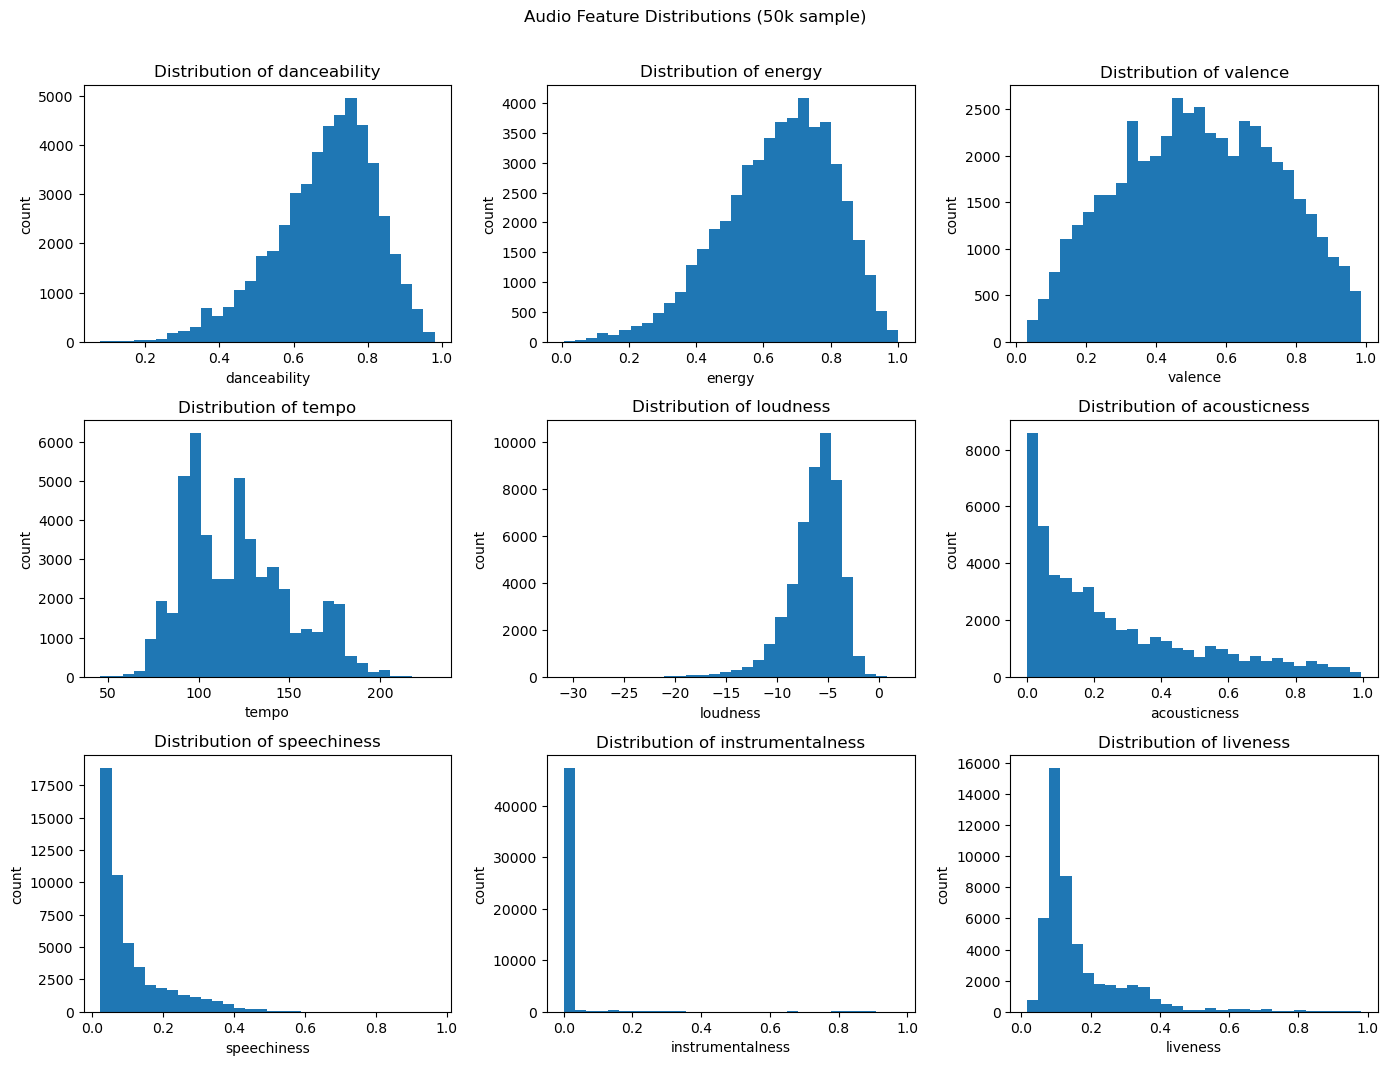

In [71]:
# Histograms of all numeric audio features 
audio_features = ["danceability", "energy", "valence", "tempo",
                   "loudness", "acousticness", "speechiness",
                   "instrumentalness", "liveness"]

n_cols = 3
n_rows = (len(audio_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    data = sample_df[feat].dropna()
    axes[i].hist(data, bins=30, edgecolor="none")
    axes[i].set_title(f"Distribution of {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("count")

# Hide unused axes
for j in range(len(audio_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Audio Feature Distributions (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


## 9) Streams vs. Numeric Features (Scatter Plots)

we plot `log(streams)` against each audio feature
to visually assess linear relationships before fitting a model.
We use `log(streams)` on the y-axis because the raw target is heavily right-skewed.


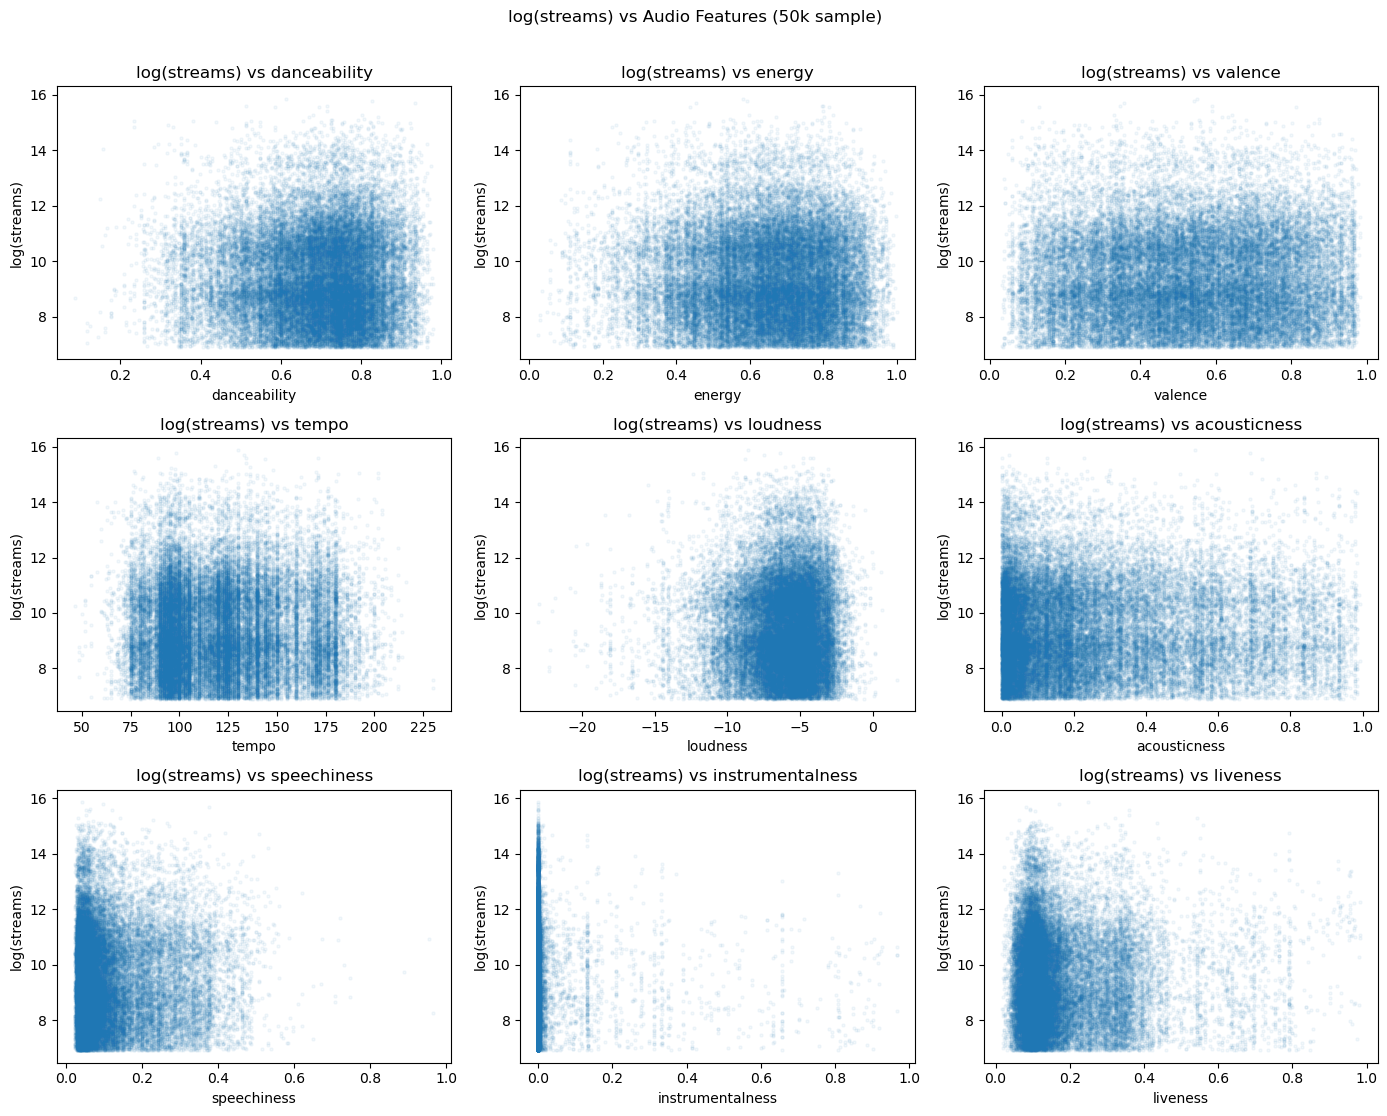

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(14, 11))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    x = sample_df[feat].dropna()
    y = sample_df.loc[x.index, "log_streams"].dropna()
    common = x.index.intersection(y.index)
    axes[i].scatter(x[common], y[common], alpha=0.05, s=5)
    axes[i].set_title(f"log(streams) vs {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("log(streams)")

plt.suptitle("log(streams) vs Audio Features (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


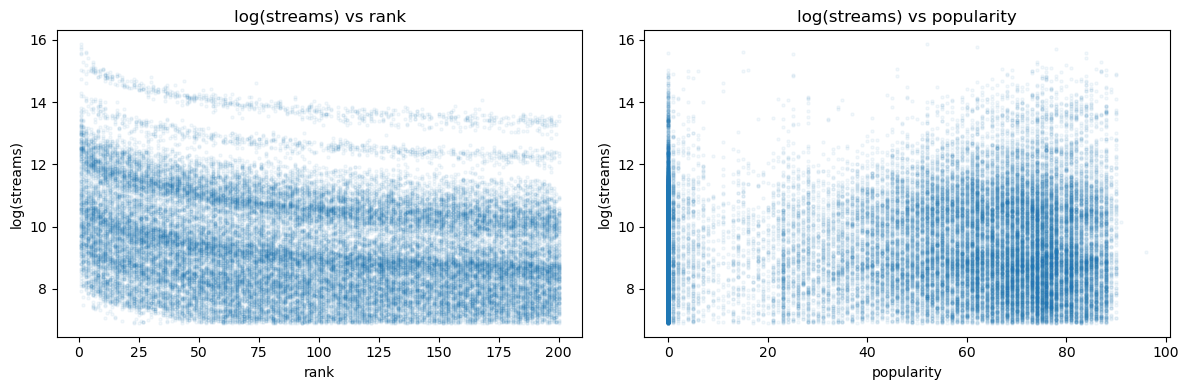

In [73]:
# Also: streams vs rank and popularity
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, feat in zip(axes, ["rank", "popularity"]):
    mask = sample_df[feat].notna() & sample_df["log_streams"].notna()
    ax.scatter(sample_df.loc[mask, feat], sample_df.loc[mask, "log_streams"],
               alpha=0.05, s=5)
    ax.set_title(f"log(streams) vs {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("log(streams)")

plt.tight_layout()
plt.show()


## 10) Categorical Effects on Streams (Box Plots)


Here we show `log(streams)` broken down by `chart` type, `explicit` flag, and `country_continent`.


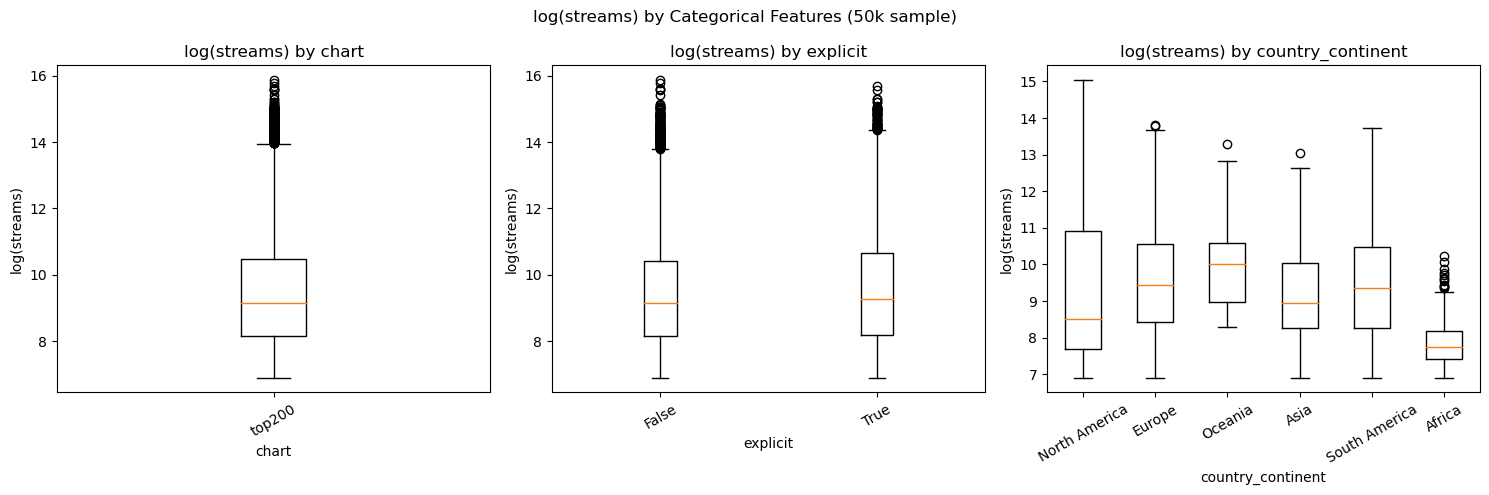

In [74]:
cat_cols = ["chart", "explicit", "country_continent"]

fig, axes = plt.subplots(1, len(cat_cols), figsize=(15, 5))

for ax, col in zip(axes, cat_cols):
    # Group data for boxplot
    groups = [
        sample_df.loc[sample_df[col] == cat, "log_streams"].dropna().values
        for cat in sample_df[col].dropna().unique()
    ]
    labels = list(sample_df[col].dropna().unique())
    # Filter out empty groups
    pairs = [(g, l) for g, l in zip(groups, labels) if len(g) > 0]
    if pairs:
        groups, labels = zip(*pairs)
        ax.boxplot(groups, labels=labels, vert=True)
        ax.set_title(f"log(streams) by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("log(streams)")
        ax.tick_params(axis="x", rotation=30)

plt.suptitle("log(streams) by Categorical Features (50k sample)")
plt.tight_layout()
plt.show()


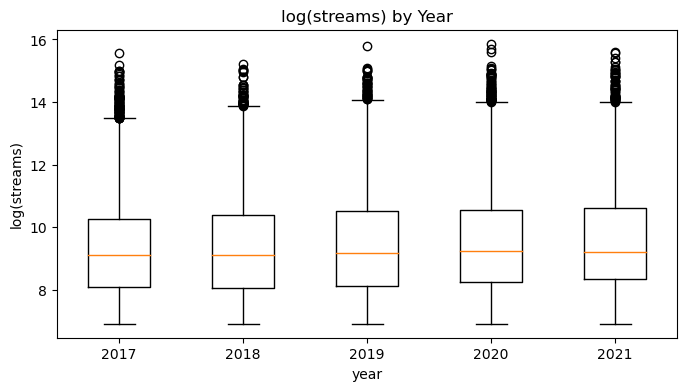

In [75]:
# Year-over-year trend boxplot 
year_groups = [
    sample_df.loc[sample_df["year"] == yr, "log_streams"].dropna().values
    for yr in sorted(sample_df["year"].dropna().unique())
]
year_labels = [str(int(yr)) for yr in sorted(sample_df["year"].dropna().unique())]

plt.figure(figsize=(8, 4))
plt.boxplot(year_groups, labels=year_labels)
plt.title("log(streams) by Year")
plt.xlabel("year")
plt.ylabel("log(streams)")
plt.show()


## 11) Correlation Matrix

Before modelling we inspect pairwise correlations between the numeric features and the target.
High correlations between features signal potential multicollinearity.


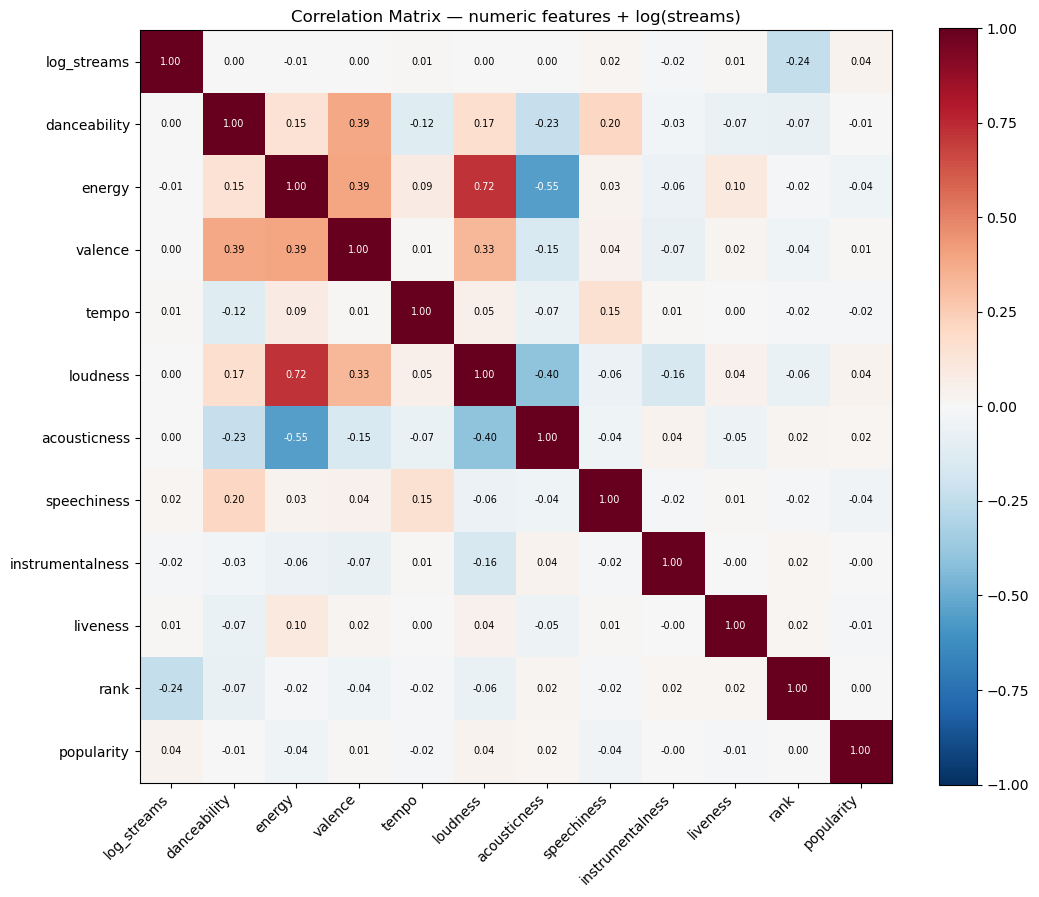


Correlations with log(streams) (sorted):
rank               -0.241074
popularity          0.035595
instrumentalness   -0.021101
speechiness         0.021012
liveness            0.012077
tempo               0.008758
energy             -0.005287
acousticness        0.003180
danceability        0.002697
loudness            0.002604
valence             0.002401


In [76]:
numeric_cols_for_corr = ["log_streams", "danceability", "energy", "valence",
                          "tempo", "loudness", "acousticness", "speechiness",
                          "instrumentalness", "liveness", "rank", "popularity"]

corr = sample_df[numeric_cols_for_corr].dropna().corr()

fig, ax = plt.subplots(figsize=(11, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(im, ax=ax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=7,
                color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

ax.set_title("Correlation Matrix — numeric features + log(streams)")
plt.tight_layout()
plt.show()

# Print top correlations with target
print("\nCorrelations with log(streams) (sorted):")
print(corr["log_streams"].drop("log_streams").sort_values(key=abs, ascending=False).to_string())


## 12) Split + Preprocess (without data leakage)
- Identify numeric and categorical features
- Build a `Pipeline` with `StandardScaler` for numeric and `OneHotEncoder` for categorical
- Perform a **75 / 25 train / test split** (`random_state=42`)

Because the full 26M-row dataset cannot fit into pandas memory, we use the **50k random sample**
already pulled in section 8. This gives a realistic and reproducible modelling baseline.

**Why a pipeline?**
- Prevents *data leakage* (scaler / encoder is fit only on train data during `.fit()`)
- Makes cross-validation safe and straightforward


In [77]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ── Define features and target ──
TARGET = "log_streams"

NUMERIC_FEATURES = [
    "danceability", "energy", "valence", "tempo",
    "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "popularity"
]
CATEGORICAL_FEATURES = ["chart", "explicit", "country_continent"]

# Drop rows where target or any feature is missing
model_df = sample_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET]].dropna()
print(f"Modelling sample after dropping NaNs: {model_df.shape}")

X = model_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = model_df[TARGET]

# ── Build preprocessing pipeline ──
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# ── Train / test split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape}  Test size: {X_test.shape}")


Modelling sample after dropping NaNs: (37492, 14)


NameError: name 'StandardScaler' is not defined

## 13) Baseline: Linear Regression

We fit a standard **least-squares linear regression**
and evaluate with:

- **RMSE** (in log-streams units)
- **R²** (fraction of variance explained)

**Checkpoint (think about these before running the next cell):**
- What does RMSE mean here if our target is `log(streams)`?
- What R² would you consider "good" for streaming data?


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ── Fit linear regression pipeline ──
lr_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

lr_pipe.fit(X_train, y_train)

# ── Predictions ──
y_train_pred = lr_pipe.predict(X_train)
y_test_pred  = lr_pipe.predict(X_test)

# ── Metrics ──
print("=== Linear Regression — Train ===")
print(f"  RMSE : {rmse(y_train, y_train_pred):.4f}")
print(f"  R²   : {r2_score(y_train, y_train_pred):.4f}")

print("\n=== Linear Regression — Test ===")
print(f"  RMSE : {rmse(y_test, y_test_pred):.4f}")
print(f"  R²   : {r2_score(y_test, y_test_pred):.4f}")

# ── Cross-validation on train set ──
cv_r2 = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring="r2")
print(f"\n5-fold CV R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


In [ ]:
# ── Actual vs Predicted — diagnostic plot ──
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.25, s=8)
lo = min(y_test.min(), y_test_pred.min())
hi = max(y_test.max(), y_test_pred.max())
axes[0].plot([lo, hi], [lo, hi], "r--", lw=1.5, label="perfect prediction")
axes[0].set_xlabel("Actual log(streams)")
axes[0].set_ylabel("Predicted log(streams)")
axes[0].set_title("Actual vs Predicted (test set)")
axes[0].legend()

# Residuals
residuals = y_test.values - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.25, s=8)
axes[1].axhline(0, color="red", lw=1.5, linestyle="--")
axes[1].set_xlabel("Predicted log(streams)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

plt.tight_layout()
plt.show()

# Residual distribution
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, edgecolor="none")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of residuals")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()

## 14) Coefficient Inspection

statsmodels OLS summary. We extract the linear regression coefficients
to understand which features drive the model.


In [ ]:
# Extract feature names after preprocessing
ohe_cats = lr_pipe.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(CATEGORICAL_FEATURES).tolist()
feature_names = NUMERIC_FEATURES + ohe_cats

# Create DataFrame with normal and absolute coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lr_pipe.named_steps["model"].coef_,
})
# Calculate the absolute value of the coefficients
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

# Sort by absolute value and display the top 15
coef_df = coef_df.sort_values("abs_coefficient", ascending=False)
print("Top 15 most influential features (by |coefficient|):")
display(coef_df.head(15))

# Extract and print the model intercept
intercept = lr_pipe.named_steps["model"].intercept_
print(f"\nModel Intercept: {intercept}")

# Bar chart of all coefficients
fig, ax = plt.subplots(figsize=(10, 6))
# Ensure chart remains sorted by influence for readability
colors = ["steelblue" if c >= 0 else "tomato" for c in coef_df["coefficient"]]
ax.barh(coef_df["feature"], coef_df["coefficient"], color=colors)
ax.axvline(0, color="black", lw=0.8)
ax.set_title("Linear Regression Coefficients")
ax.set_xlabel("Coefficient value")
plt.tight_layout()
plt.show()

## Interpreting the linear model coefficients (what increases/decreases predictions)

**Rule:**  
- **Positive coefficient (+)** → increases the prediction  
- **Negative coefficient (−)** → decreases the prediction  
- For **dummy variables** (e.g., `country_continent_Europe`), the coefficient is the effect **relative to the omitted reference category** (the continent that has no dummy).

### If the target is `log(streams)` (as in our EDA)
Then coefficients are easiest to read as **multiplicative / % effects**:

- A coefficient **β** corresponds to multiplying streams by **exp(β)**  
- Approx. percent change: **(exp(β) − 1) × 100%**

### Which variables increase predictions?
Largest positive effects (vs. reference continent):
- `country_continent_Oceania` **(+2.059)** → exp(2.059) ≈ **7.84×** (≈ **+684%**)
- `country_continent_South America` **(+1.618)** → ≈ **5.05×** (≈ **+405%**)
- `country_continent_Europe` **(+1.600)** → ≈ **4.95×** (≈ **+395%**)
- `country_continent_North America` **(+1.482)** → ≈ **4.40×** (≈ **+340%**)
- `country_continent_Asia` **(+1.267)** → ≈ **3.55×** (≈ **+255%**)

Other positive effects:
- `explicit_True` **(+0.086)** → exp(0.086) ≈ **1.09×** (≈ **+9%**)
- Small positives: `acousticness`, `liveness`, `valence`, `tempo`, `popularity`, `energy`

### Which variables decrease predictions?
- `danceability` **(−0.027)**
- `instrumentalness` **(−0.021)**
- `loudness` **(−0.020)**

(If the target is log(streams), β = −0.027 means exp(−0.027) ≈ **0.973×** → about **−2.7%** for a +1 unit change in that feature.)

### Are effects large or small?
- **Very large:** the **continent dummies** (coefficients ~1.3–2.1) dominate the model → they change predictions by **multiples**.
- **Medium:** `explicit_True` (~0.086) → around **single-digit %** effect.
- **Small:** most audio features have |β| around **0.02–0.03** (small changes in predicted log(streams)).

 Important: comparing “importance” by |coefficient| only makes sense if features are on **similar scales** (e.g., standardized). If not standardized, coefficient size also reflects the feature’s units (tempo in BPM, popularity 0–100, etc.).

### Are signs intuitive?
- **Instrumentalness negative**: intuitive (instrumentals often stream less in mainstream charts).
- **Popularity positive**: intuitive.
- **Continent effects**: plausible (differences in market size / Spotify usage / chart mechanics), but not causal.
- **Danceability negative / loudness negative**: might be counterintuitive and can depend on **scaling**, omitted variables, or correlations among features (multicollinearity). These signs should be discussed as “associations,” not causal effects.

**Intercept:** 7.83 means the baseline prediction (when all features = 0 and the reference categories apply) is **log(streams)=7.83** (streams ≈ exp(7.83) ≈ 2,517), but this baseline may not be realistic if “0” is outside typical feature values.


## 15) Regularization: Ridge | Lasso | ElasticNet

### Why Regularization?
Real datasets often have:
- Multicollinearity (e.g. energy and loudness are correlated)
- Noise
- Many one-hot-encoded dummy features

**Ridge** adds an L2 penalty to shrink all coefficients; **Lasso** adds an L1 penalty and can zero out irrelevant features.
Both reduce overfitting and improve generalization.**ElasticNet** is a modebel which behaves like Ridge (stable) + Lasso (some selection)
,especially good when predictors are correlated and you want interpretability.

In [ ]:
rows = []

ridge_alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
enet_alphas  = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios    = [0.2, 0.5, 0.8]

# --- LinearRegression ---
pipe = Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
pipe.fit(X_train, y_train)
rows.append({
    "train_rmse": rmse(y_train, pipe.predict(X_train)),
    "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
    "train_r2":   r2_score(y_train, pipe.predict(X_train)),
    "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
    "model":      "LinearRegression",
    "alpha":      np.nan
})

# --- Ridge ---
for a in ridge_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=a))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Ridge",
        "alpha":      a
    })

# --- Lasso ---
for a in lasso_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=a, max_iter=20000))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Lasso",
        "alpha":      a
    })

# --- ElasticNet (encode l1_ratio into model name so column isn't needed) ---
for a in enet_alphas:
    for r in l1_ratios:
        pipe = Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=a, l1_ratio=r, max_iter=20000))])
        pipe.fit(X_train, y_train)
        rows.append({
            "train_rmse": rmse(y_train, pipe.predict(X_train)),
            "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
            "train_r2":   r2_score(y_train, pipe.predict(X_train)),
            "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
            "model":      f"ElasticNet(r={r})",
            "alpha":      a
        })

results_df = pd.DataFrame(rows)
results_df[["train_rmse","test_rmse","train_r2","test_r2"]] = results_df[["train_rmse","test_rmse","train_r2","test_r2"]].round(6)
results_df["alpha"] = results_df["alpha"].round(6)

results_df = results_df.sort_values(["test_rmse", "test_r2"], ascending=[True, False]).reset_index(drop=True)
display(results_df)

In [ ]:
# ── Pick the best alpha per model family from the grid search ─────────────────
# We take the row with the lowest test_rmse for each model family.
# ElasticNet variants are grouped by their full name (which encodes l1_ratio).

best_configs = (
    results_df
    .loc[results_df.groupby("model")["test_rmse"].idxmin()]
    .reset_index(drop=True)
)
print("Best config per model family (by test RMSE):")
display(best_configs[["model", "alpha", "test_rmse", "test_r2"]])

# Build the winning pipelines
def build_pipe(model_name: str, alpha: float) -> Pipeline:
    if model_name == "LinearRegression":
        return Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
    elif model_name == "Ridge":
        return Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=alpha))])
    elif model_name == "Lasso":
        return Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=alpha, max_iter=20000))])
    elif model_name.startswith("ElasticNet"):
        # parse l1_ratio from the encoded name, e.g. "ElasticNet(r=0.5)"
        l1 = float(model_name.split("r=")[1].rstrip(")"))
        return Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=20000))])
    else:
        raise ValueError(f"Unknown model: {model_name}")

# 5-fold CV on the BEST config per family
# cross_val_score returns *negative* RMSE → multiply by -1

cv_rows = []

for _, row in best_configs.iterrows():
    name  = row["model"]
    alpha = row["alpha"]
    pipe  = build_pipe(name, alpha)

    neg_rmse_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    rmse_scores = -neg_rmse_scores

    cv_rows.append({
        "model":          name,
        "alpha":          alpha,
        "cv_rmse_mean":   round(rmse_scores.mean(), 4),
        "cv_rmse_std":    round(rmse_scores.std(),  4),
        "fold_scores":    rmse_scores.round(4).tolist(),
        "test_rmse":      row["test_rmse"],   # from grid search — for comparison
    })

    print(f"{name}  (alpha={alpha})")
    print(f"  CV RMSE per fold : {rmse_scores.round(4)}")
    print(f"  Mean CV RMSE     : {rmse_scores.mean():.4f}")
    print(f"  Std  CV RMSE     : {rmse_scores.std():.4f}")
    print()

# ── Summary table ─────────────────────────────────────────────────────────────
cv_summary = pd.DataFrame(cv_rows).sort_values("cv_rmse_mean").reset_index(drop=True)
cv_summary["gap (cv - test)"] = (cv_summary["cv_rmse_mean"] - cv_summary["test_rmse"]).round(4)
print("CV summary (sorted by Mean CV RMSE):")
display(cv_summary[["model", "alpha", "cv_rmse_mean", "cv_rmse_std", "test_rmse", "gap (cv - test)"]])

# ── Boxplot: CV RMSE spread per winning model ─────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
labels = [r["model"] for r in cv_rows]
data   = [r["fold_scores"] for r in cv_rows]
bp = ax.boxplot(data, labels=labels, patch_artist=True)

colors = plt.cm.tab10.colors
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel("CV RMSE (5 folds)")
ax.set_title("5-Fold CV RMSE — Best Config per Model Family")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()

## 16) Gradient Descent — From Scratch



This section is for *conceptual reinforcement*. We re-implement linear regression
using **batch gradient descent** on the same preprocessed design matrix, then compare
results to sklearn's closed-form solution.

**How it works:**
1. Start with `θ = 0` (all-zero coefficients)
2. Compute predictions: `ŷ = X · θ`
3. Compute gradient of MSE: `∇ = (2/m) · Xᵀ(ŷ − y)`
4. Update: `θ ← θ − lr · ∇`
5. Repeat for `n_iter` steps

**Checkpoint (think about these before running):**
- What happens if the learning rate `lr` is too high? Too low?
- How do we know we've converged?
- Why must features be standardised before gradient descent?

## Why Gradient Descent Matters
This section shows *how* models learn under the hood:
- Start with random / zero coefficients
- Iteratively reduce the training error
- Converge toward the optimal solution

Focus on the concept — not every line of maths.


In [ ]:
# ── Step 1: Extract the preprocessed design matrix ──────────────────────────
# Reuse the already-fit preprocessor from lr_pipe (section 13)
# Refit here so this cell works even if run out of order
preprocess_fit = preprocess.fit(X_train)

X_train_gd = preprocess_fit.transform(X_train)
X_test_gd  = preprocess_fit.transform(X_test)

# Convert to dense if sparse
X_train_gd = X_train_gd.toarray() if hasattr(X_train_gd, "toarray") else X_train_gd
X_test_gd  = X_test_gd.toarray()  if hasattr(X_test_gd,  "toarray") else X_test_gd

# ── Step 2: Prepend intercept column (column of 1s) ──────────────────────────
X_train_gd = np.c_[np.ones(X_train_gd.shape[0]), X_train_gd]
X_test_gd  = np.c_[np.ones(X_test_gd.shape[0]),  X_test_gd]

print(f"X_train_gd shape: {X_train_gd.shape}  (includes intercept column)")
print(f"X_test_gd  shape: {X_test_gd.shape}")


In [ ]:
# ── Step 3: Gradient Descent implementation ──────────────────────────────────
def gradient_descent(X, y, lr=0.05, n_iter=2000):
    """Batch gradient descent for linear regression (MSE loss).

    Parameters
    ----------
    X      : (m, n+1) design matrix with intercept column prepended
    y      : (m,) target vector
    lr     : learning rate
    n_iter : number of gradient steps

    Returns
    -------
    theta   : (n+1,) learned coefficient vector
    history : (n_iter,) MSE at each iteration
    """
    theta = np.zeros(X.shape[1])  # initialise all weights at 0
    m = X.shape[0]
    history = []
    for _ in range(n_iter):
        y_pred = X @ theta                          # forward pass
        grad   = (2 / m) * (X.T @ (y_pred - y))    # gradient of MSE
        theta -= lr * grad                          # weight update
        history.append(mean_squared_error(y, y_pred))
    return theta, np.array(history)


theta_gd, mse_hist = gradient_descent(
    X_train_gd, y_train.values, lr=0.05, n_iter=2000
)

# ── Step 4: Plot training MSE convergence ────────────────────────────────────
plt.figure(figsize=(7, 4))
plt.plot(mse_hist, lw=1.5)
plt.title("Gradient Descent — training MSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()


In [ ]:
# ── Step 5: Evaluate on test set and compare to sklearn's closed-form ────────
y_test_pred_gd = X_test_gd @ theta_gd

rmse_gd = rmse(y_test, y_test_pred_gd)
r2_gd   = float(r2_score(y_test, y_test_pred_gd))

# Retrieve sklearn closed-form results from section 13
rmse_lr = rmse(y_test, y_test_pred)
r2_lr   = float(r2_score(y_test, y_test_pred))

print("=" * 45)
print(f"{'Model':<30} {'RMSE':>8} {'R²':>8}")
print("-" * 45)
print(f"{'sklearn LinearRegression':<30} {rmse_lr:>8.4f} {r2_lr:>8.4f}")
print(f"{'Gradient Descent (lr=0.05, 2000 iters)':<30} {rmse_gd:>8.4f} {r2_gd:>8.4f}")
print("=" * 45)
print("\nBoth should be very close — gradient descent converges to the same minimum.")
print("If they differ, try increasing n_iter or decreasing lr.")

# sensitivity to learning rate ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
for lr_val in [0.001, 0.01, 0.05, 0.1]:
    _, hist = gradient_descent(X_train_gd, y_train.values, lr=lr_val, n_iter=300)
    ax.plot(hist, label=f"lr={lr_val}")

ax.set_title("Effect of learning rate on convergence (first 300 iterations)")
ax.set_xlabel("Iteration")
ax.set_ylabel("MSE")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()


hallo julius 